# Main ML pipeline

In [44]:
from pandas.core.common import random_state
from qiskit.visualization import plot_histogram
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import os
from scripts.ned_calculator import NedCalculator
import shutil
import seaborn as sns


In [45]:
results_summary = pd.DataFrame(columns=['name', 'features', 'test_r2', 'train_avg_r2', 'feature_importances'])

test_predictions = {}  # Format: {name: {ID: {seed: prediction}}}
train_predictions = {}  # Format: {name: {index: {seed: prediction}}}

def test_regression_on_INSPIRE(name, FEATURES,test_df, train_df,MODEL_PARAMS, plotting=False, random_state=1):
    
    # Extract features and target
    X_train = train_df[FEATURES]
    y_train = train_df['DoR']
    X_test = test_df[FEATURES]
    y_test = test_df['DoR']
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train the model
    # print("Training the model...")
    rf_model = RandomForestRegressor(**MODEL_PARAMS)
    rf_model.fit(X_train_scaled, y_train)
    
        # Get feature importances and store as dictionary
    feature_importance_dict = dict(zip(FEATURES, rf_model.feature_importances_))
    
    
    # Make predictions on test data
    # print("Making predictions on test data...")
    y_pred = rf_model.predict(X_test_scaled)

    if name not in test_predictions:
        test_predictions[name] = {}
    for idx, id_val in enumerate(test_df['ID_INSPIRE']):
        if id_val not in test_predictions[name]:
            test_predictions[name][id_val] = {}
        test_predictions[name][id_val][random_state] = y_pred[idx]
    
    # Calculate residuals
    residuals = y_test - y_pred
    
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    # print(f"Test R²: {r2:.4f}")
    # print(f"Test RMSE: {rmse:.4f}")
    # print(f"Test MAE: {mae:.4f}")
    small_boundary = 0.35
    large_boundary = 0.6
    small_mask = y_pred <= small_boundary
    mid_mask = (y_pred > small_boundary) & (y_pred < large_boundary)
    large_mask = y_pred >= large_boundary
        
    small_rmse = np.sqrt(mean_squared_error(y_test[small_mask], y_pred[small_mask])) if np.any(small_mask) else np.nan
    mid_rmse = np.sqrt(mean_squared_error(y_test[mid_mask], y_pred[mid_mask])) if np.any(mid_mask) else np.nan
    large_rmse = np.sqrt(mean_squared_error(y_test[large_mask], y_pred[large_mask])) if np.any(large_mask) else np.nan
        
    
    if plotting:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 16), sharex=True, gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.05})
        
        # Plot settings
        plt.rcParams.update({
            "text.usetex": True,
            "font.family": "Computer Modern",
            "figure.dpi": 300,
            "font.size": 15,
        })
        
        SNR_values = test_df['SNR_MEAN']

        # ax1.scatter(y_pred, y_test, alpha=0.7, s=35, color='royalblue', edgecolors='k', linewidths=0.5)
        scatter = ax1.scatter(y_pred, y_test, alpha=0.7, s=35, c=SNR_values, 
                         cmap='viridis', edgecolors='k', linewidths=0.5)
        
        min_val = min(min(y_test), min(y_pred))
        max_val = max(max(y_test), max(y_pred))
        buffer = (max_val - min_val) * 0.02
        plot_min = min_val - buffer
        plot_max = max_val + buffer
        
        ax1.plot([plot_min, plot_max], [plot_min, plot_max], 'r--', 
                label='Perfect prediction', linewidth=1.5)
    
        
        ax1.set_ylabel('True DoR', fontsize=16)
        ax1.set_xlim(plot_min, plot_max)
        ax1.set_ylim(plot_min, plot_max)

        
        # Add textbox with performance metrics to top plot
        props = dict(boxstyle='square', facecolor='white', alpha=0.8, edgecolor='lightgray')
        textstr = '\n'.join((
            r'$\mathrm{R}^2 = %.4f$' % (r2,),
            r'$\mathrm{RMSE} = %.4f$' % (rmse,),
        ))
        ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=14,
                verticalalignment='top', bbox=props)
        
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='both', which='both', direction='in', labelsize=14)
        ax1.minorticks_on()
        for spine in ax1.spines.values():
            spine.set_color('lightgray')
        
        # ax2.scatter(y_pred, residuals, alpha=0.7, s=35, color='royalblue', edgecolors='k', linewidths=0.5)
        ax2.scatter(y_pred, residuals, alpha=0.7, s=35, c=SNR_values, 
                    cmap='viridis', edgecolors='k', linewidths=0.5)
        ax2.axhline(y=0, color='r', linestyle='--', linewidth=1.5)
        
        
        ax2.set_xlabel('Predicted DoR', fontsize=16)
        ax2.set_ylabel('Residuals (True - Predicted)', fontsize=16)
        
                
        cbar = fig.colorbar(scatter, ax=ax2)
        cbar.set_label('SNR', rotation=270, labelpad=15, fontsize=14)
        
        #cbar = fig.colorbar(scatter, ax=ax2, orientation='horizontal', pad=0.15)
        #cbar.set_label('SNR', fontsize=14)
        
        # Add textbox with region-specific RMSE to bottom plot
        props = dict(boxstyle='square', facecolor='white', alpha=0.8, edgecolor='lightgray')
        textstr = '\n'.join((
            r'$\mathrm{Overall\ RMSE} = %.4f$' % (rmse,),
            r'$\mathrm{RMSE\ (DoR \leq %.2f)} = %.4f$' % (small_boundary, small_rmse),
            r'$\mathrm{RMSE\ (%.2f < DoR < %.2f)} = %.4f$' % (small_boundary, large_boundary, mid_rmse),
            r'$\mathrm{RMSE\ (DoR \geq %.2f)} = %.4f$' % (large_boundary, large_rmse)
        ))
        ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=14,
                verticalalignment='top', bbox=props)
        
        # Add grid and styling to bottom plot
        ax2.grid(True, alpha=0.3)
        ax2.tick_params(axis='both', which='both', direction='in', labelsize=14)
        ax2.minorticks_on()
        for spine in ax2.spines.values():
            spine.set_color('lightgray')
        
        plt.tight_layout()
        plt.savefig('tests/'+name+'_test.pdf', bbox_inches='tight')
        # plt.show()
    
    # print(f"\nRegion-specific RMSE:")
    # print(f"RMSE (DoR ≤ {small_boundary}): {small_rmse:.4f}")
    # print(f"RMSE ({small_boundary} < DoR < {large_boundary}): {mid_rmse:.4f}")
    # print(f"RMSE (DoR ≥ {large_boundary}): {large_rmse:.4f}")
    
    inspection_df = pd.DataFrame({
    'Index': test_df.index,
    'True_DoR': y_test,
    'Predicted_DoR': y_pred,
    'ID': test_df['ID_INSPIRE']
    })

    inspection_df['absolute_residual'] = abs(inspection_df['True_DoR'] - inspection_df['Predicted_DoR'])
    inspection_df = inspection_df.sort_values('absolute_residual', ascending=False)
    #print("Largest absolute residuals:")
    #print(inspection_df.head(5)) # len(inspection_df)))

    global results_summary
    results_summary = pd.concat([results_summary, pd.DataFrame({
        'name': [name],
        'features': [', '.join(FEATURES)],
        'test_r2': [r2],
        'train_avg_r2': [None],  # Will be filled in by visualize_kfold_predictions_training
        'feature_importances': [feature_importance_dict],
        'random_seed': [random_state]  # Add random_state to track different runs
    })], ignore_index=True)
    
    visualize_kfold_predictions_training(train_df, FEATURES, name, model_params=MODEL_PARAMS, plotting=plotting)

def visualize_kfold_predictions_training(df, features, name, target='DoR', n_splits=5, model_params=None, 
                                 small_boundary=0.35, large_boundary=0.6, plotting=False):
    # print(model_params)
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "Computer Modern",
        "figure.dpi": 300,
        "font.size": 15,
    })
    
    X = df[features]
    y = df[target]
    
    # Set up K-Fold cross-validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=model_params['random_state'])
    
    # Initialize arrays to store all predictions
    all_true = np.zeros_like(y)
    all_pred = np.zeros_like(y)
    all_residuals = np.zeros_like(y)
    fold_indices = np.zeros_like(y, dtype=int)  # Track which fold each point belongs to
    fold_results = {
        'r2_scores': [],
        'indices': [],
        'predictions': [],
        'true_values': [],
    }
    
    # Define colors for different folds
    fold_colors = plt.cm.tab10(np.linspace(0, 1, n_splits))
    
    # Perform k-fold cross-validation
    for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
        # Split and scale data
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Train model and make predictions
        rf_model = RandomForestRegressor(**model_params)
        rf_model.fit(X_train_scaled, y_train)
        y_pred = rf_model.predict(X_test_scaled)
        
        if name not in train_predictions:
            train_predictions[name] = {}
        for idx, pred_val in zip(test_idx, y_pred):
            if idx not in train_predictions[name]:
                train_predictions[name][idx] = {}
            train_predictions[name][idx][model_params['random_state']] = pred_val
        
        # Store results for this fold
        r2 = r2_score(y_test, y_pred)
        fold_results['r2_scores'].append(r2)
        fold_results['indices'].append(test_idx)
        fold_results['predictions'].append(y_pred)
        fold_results['true_values'].append(y_test.values)
        
        # Store predictions and residuals at the correct indices
        all_true[test_idx] = y_test
        all_pred[test_idx] = y_pred
        all_residuals[test_idx] = y_test - y_pred
        fold_indices[test_idx] = fold  # Track which fold this point belongs to
        
        # print(f"Fold {fold}/{n_splits} - R²: {r2:.4f}")
    
    # Calculate overall R² for all folds combined
    overall_r2 = r2_score(all_true, all_pred)
    mean_fold_r2 = np.mean(fold_results['r2_scores'])
    std_fold_r2 = np.std(fold_results['r2_scores'])
    
    mask = (results_summary['name'] == name) & (results_summary['random_seed'] == model_params['random_state'])
    results_summary.loc[mask, 'train_avg_r2'] = mean_fold_r2
    
    # Calculate overall RMSE and MAE
    rmse = np.sqrt(mean_squared_error(all_true, all_pred))
    mae = mean_absolute_error(all_true, all_pred)
    
    # print(f"\nCross-validation results:")
    # print(f"Mean fold R²: {mean_fold_r2:.4f} (±{std_fold_r2:.4f})")
    # print(f"Overall R² (all predictions): {overall_r2:.4f}")
    # print(f"Overall RMSE: {rmse:.4f}")
    # print(f"Overall MAE: {mae:.4f}")
    
    if plotting:
        # Create figure with two subplots sharing x-axis
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 16), sharex=True, gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.05})
        
        # Find plot limits
        min_val = min(min(all_true), min(all_pred))
        max_val = max(max(all_true), max(all_pred))
        buffer = (max_val - min_val) * 0.02
        plot_min = min_val - buffer
        plot_max = max_val + buffer
        
        # Top subplot: True vs Predicted
        # Plot each fold with different colors - x=predicted, y=true
        for fold in range(1, n_splits + 1):
            mask = fold_indices == fold
            ax1.scatter(all_pred[mask], all_true[mask], alpha=0.7, s=35,
                       color=fold_colors[fold - 1], edgecolors='k', linewidths=0.5,
                       label=f'Fold {fold} (R²: {fold_results["r2_scores"][fold - 1]:.4f})')
        
        # Add perfect prediction line
        ax1.plot([plot_min, plot_max], [plot_min, plot_max], 'r--',
                 label='Perfect prediction', linewidth=1.5)
        
        # Customize top plot
        ax1.set_ylabel('True DoR', fontsize=16)
        ax1.set_xlim(plot_min, plot_max)
        ax1.set_ylim(plot_min, plot_max)
        
        # Add textbox with performance metrics for top plot
        props = dict(boxstyle='square', facecolor='white', alpha=0.8, edgecolor='lightgray')
        textstr = '\n'.join((
            r'$\mathrm{Mean}\ R^2 = %.4f\ (\pm%.4f)$' % (mean_fold_r2, std_fold_r2),
        ))
        ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=14,
                 verticalalignment='top', bbox=props)
        
        ax1.legend(loc='lower right', fontsize=10)
        
        # Add grid and styling to top plot
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='both', which='both', direction='in', labelsize=14)
        ax1.minorticks_on()
        for spine in ax1.spines.values():
            spine.set_color('lightgray')
        
        # Bottom subplot: Residuals vs Predicted
        for fold in range(1, n_splits + 1):
            mask = fold_indices == fold
            ax2.scatter(all_pred[mask], all_residuals[mask], alpha=0.7, s=35,
                       color=fold_colors[fold - 1], edgecolors='k', linewidths=0.5,
                       label=f'Fold {fold}')
        
        ax2.axhline(y=0, color='r', linestyle='--', linewidth=1.5)
        
        # Calculate region-specific RMSE by predicted DoR
        small_mask = all_pred <= small_boundary
        mid_mask = (all_pred > small_boundary) & (all_pred < large_boundary)
        large_mask = all_pred >= large_boundary
        
        small_rmse = np.sqrt(mean_squared_error(all_true[small_mask], all_pred[small_mask])) if np.any(small_mask) else np.nan
        mid_rmse = np.sqrt(mean_squared_error(all_true[mid_mask], all_pred[mid_mask])) if np.any(mid_mask) else np.nan
        large_rmse = np.sqrt(mean_squared_error(all_true[large_mask], all_pred[large_mask])) if np.any(large_mask) else np.nan
        
        # Customize bottom plot
        ax2.set_xlabel('Predicted DoR', fontsize=16)
        ax2.set_ylabel('Residuals (True - Predicted)', fontsize=16)
        
        # Add region-specific metrics in a textbox for bottom plot
        props = dict(boxstyle='square', facecolor='white', alpha=0.8, edgecolor='lightgray')
        textstr = '\n'.join((
            r'$\mathrm{Overall\ RMSE} = %.4f$' % (rmse,),
            r'$\mathrm{RMSE\ (DoR \leq %.2f)} = %.4f$' % (small_boundary, small_rmse),
            r'$\mathrm{RMSE\ (%.2f < DoR < %.2f)} = %.4f$' % (small_boundary, large_boundary, mid_rmse),
            r'$\mathrm{RMSE\ (DoR \geq %.2f)} = %.4f$' % (large_boundary, large_rmse)
        ))
        ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=14,
                verticalalignment='top', bbox=props)
        
        # Add grid and styling to bottom plot
        ax2.grid(True, alpha=0.3)
        ax2.tick_params(axis='both', which='both', direction='in', labelsize=14)
        ax2.minorticks_on()
        for spine in ax2.spines.values():
            spine.set_color('lightgray')
        
        plt.tight_layout()
        plt.savefig('tests/'+name+'_train_cv.pdf', bbox_inches='tight')
        # plt.show()
    
        return fig
       
'''def calculate_ensemble_metrics():
    """Calculate metrics based on ensemble (averaged) predictions across seeds."""
    ensemble_results = pd.DataFrame(columns=['name', 'ensemble_test_r2', 'ensemble_test_rmse', 
                                            'ensemble_train_r2', 'ensemble_train_rmse'])
    
    for name in test_predictions:
        # Calculate test metrics
        test_r2, test_rmse = visualize_ensemble_predictions_all(name, dataset_type='test')
        
        # Calculate train metrics if available
        train_r2, train_rmse = np.nan, np.nan
        if name in train_predictions and train_predictions[name]:
            try:
                train_r2, train_rmse = visualize_ensemble_predictions_all(name, dataset_type='train')
            except Exception as e:
                print(f"Error calculating train metrics for {name}: {e}")
        
        # Add to results
        ensemble_results = pd.concat([ensemble_results, pd.DataFrame({
            'name': [name],
            'ensemble_test_r2': [test_r2],
            'ensemble_test_rmse': [test_rmse],
            'ensemble_train_r2': [train_r2],
            'ensemble_train_rmse': [train_rmse]
        })], ignore_index=True)
    
    # Print results
    print("\nEnsemble Metrics (Averaged Predictions Across Seeds):")
    print("=" * 120)
    print(ensemble_results.to_string(index=False, float_format=lambda x: f"{x:.4f}"))
    print("=" * 120)
    
    # Save to CSV
    ensemble_results.to_csv('tests/ensemble_results.csv', index=False)
    
    return ensemble_results

def visualize_ensemble_predictions_all(model_name, dataset_type='test'):
    if dataset_type not in ['test', 'train']:
        print(f"Invalid dataset type: {dataset_type}. Must be 'test' or 'train'.")
        return
    
    # Choose appropriate predictions dictionary and dataframe
    predictions_dict = test_predictions if dataset_type == 'test' else train_predictions
    df = test_df if dataset_type == 'test' else train_df
    
    if model_name not in predictions_dict:
        print(f"No {dataset_type} predictions found for model: {model_name}")
        return
    
    # Set plotting style
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "Computer Modern",
        "figure.dpi": 300,
        "font.size": 15,
    })
    
    # Get data
    data_points = list(predictions_dict[model_name].keys())
    
    # Create mappings from data points to true values and SNR
    if dataset_type == 'test':
        # For test data, we use ID_INSPIRE as the key
        point_to_true = {id_val: test_df.loc[test_df['ID_INSPIRE'] == id_val, 'DoR'].values[0] 
                          for id_val in data_points}
        point_to_snr = {id_val: test_df.loc[test_df['ID_INSPIRE'] == id_val, 'SNR'].values[0] 
                         for id_val in data_points}
    else:
        # For train data, we use dataframe indices as keys
        point_to_true = {idx: train_df.loc[idx, 'DoR'] for idx in data_points}
        point_to_snr = {idx: train_df.loc[idx, 'SNR'] for idx in data_points}
    
    # Calculate average and std of predictions
    y_true = []
    y_pred_avg = []
    y_pred_std = []
    snr_values = []
    
    for id_val in data_points:
        predictions = list(predictions_dict[model_name][id_val].values())
        if predictions and id_val in point_to_true and id_val in point_to_snr:
            y_true.append(point_to_true[id_val])
            y_pred_avg.append(np.mean(predictions))
            y_pred_std.append(np.std(predictions))
            snr_values.append(point_to_snr[id_val])
    
    # Convert to numpy arrays for calculations
    y_true = np.array(y_true)
    y_pred_avg = np.array(y_pred_avg)
    y_pred_std = np.array(y_pred_std)
    snr_values = np.array(snr_values)
    
    # Remove NaN values
    valid_indices = ~np.isnan(y_pred_avg) & ~np.isnan(snr_values)
    if np.sum(valid_indices) < 10:  # Require at least 10 valid points
        print(f"Not enough valid predictions for {dataset_type} data in model: {model_name}")
        return
    
    y_true = y_true[valid_indices]
    y_pred_avg = y_pred_avg[valid_indices]
    y_pred_std = y_pred_std[valid_indices]
    snr_values = snr_values[valid_indices]
    
    # Calculate metrics
    r2 = r2_score(y_true, y_pred_avg)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred_avg))
    
    # Create plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 16), sharex=True, 
                                  gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.05})
    
    # Plot True vs Predicted with SNR coloring
    scatter1 = ax1.scatter(y_pred_avg, y_true, c=snr_values, cmap='viridis', 
                         s=50, alpha=0.7, edgecolors='none')
    
    # Draw error bars using errorbar function with no markers
    # Only draw horizontal error bars for x-axis
    ax1.errorbar(y_pred_avg, y_true, xerr=y_pred_std, fmt='none', ecolor='#000000', 
                 elinewidth=0.2, capsize=0)
    
    # Set fixed limits from 0.1 to 0.9 for both axes
    ax1.set_xlim(0.1, 0.9)
    ax1.set_ylim(0.1, 0.9)
    
    # Create consistent tick marks with 0.1 increments
    ticks = np.arange(0.1, 1.0, 0.1)
    ax1.set_xticks(ticks)
    ax1.set_yticks(ticks)
    ax1.set_xticklabels([f'{t:.1f}' for t in ticks])
    ax1.set_yticklabels([f'{t:.1f}' for t in ticks])
    
    # Add perfect prediction line
    ax1.plot([0.1, 0.9], [0.1, 0.9], 'r--', 
             label='Perfect prediction', linewidth=1.5)
    
    # Add annotations
    props = dict(boxstyle='square', facecolor='white', alpha=0.8, edgecolor='lightgray')
    textstr = '\n'.join((
        r'$\mathrm{Ensemble}\ \mathrm{R}^2 = %.4f$' % (r2,),
        r'$\mathrm{Ensemble}\ \mathrm{RMSE} = %.4f$' % (rmse,),
    ))
    ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=14,
             verticalalignment='top', bbox=props)
    
    # Style plot
    ax1.set_ylabel('True DoR', fontsize=16)
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='both', which='both', direction='in', labelsize=14)
    ax1.minorticks_on()
    
    # Plot residuals
    residuals = y_true - y_pred_avg
    scatter2 = ax2.scatter(y_pred_avg, residuals, c=snr_values, cmap='viridis',
                         s=50, alpha=0.7, edgecolors='none')
    
    # Draw error bars for residuals using errorbar function
    ax2.errorbar(y_pred_avg, residuals, xerr=y_pred_std, fmt='none', ecolor='#000000', 
                 elinewidth=0.2, capsize=0)
    
    ax2.axhline(y=0, color='r', linestyle='--', linewidth=1.5)
    
    # Set consistent tick marks for x-axis in bottom plot (shared with top plot)
    # and set appropriate limits for residuals based on data
    residual_max = max(abs(np.min(residuals)), abs(np.max(residuals)))
    residual_limit = min(0.5, np.ceil(residual_max * 10) / 10)  # Round up to nearest 0.1
    ax2.set_ylim(-residual_limit, residual_limit)
    
    # Create even tick marks for residuals
    residual_ticks = np.arange(-residual_limit, residual_limit + 0.1, 0.1).round(1)
    ax2.set_yticks(residual_ticks)
    ax2.set_yticklabels([f'{t:.1f}' for t in residual_ticks])
    
    # Keep consistent x-ticks from top plot
    ax2.set_xlim(0.1, 0.9)
    ax2.set_xticks(ticks)
    ax2.set_xticklabels([f'{t:.1f}' for t in ticks])
    
    # Style residual plot
    ax2.set_xlabel('Predicted DoR (Ensemble Average)', fontsize=16)
    ax2.set_ylabel('Residuals', fontsize=16)
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='both', which='both', direction='in', labelsize=14)
    ax2.minorticks_on()
    
    # Add colorbar to the bottom plot
    cbar = fig.colorbar(scatter2, ax=ax2)
    cbar.set_label('SNR', rotation=270, labelpad=15, fontsize=14)
    
    plt.tight_layout()
    plt.savefig(f'tests/{model_name}_{dataset_type}_ensemble.pdf', bbox_inches='tight')
    plt.close()
    
    return r2, rmse
'''


'''def calculate_ensemble_metrics():
    """Calculate metrics based on ensemble (averaged) predictions across seeds."""
    ensemble_results = pd.DataFrame(columns=['name', 'ensemble_test_r2', 'ensemble_test_rmse', 
                                            'ensemble_train_r2', 'ensemble_train_rmse'])
    
    for name in test_predictions:
        # Calculate test metrics
        test_r2, test_rmse = calculate_metrics_for_dataset(name, 'test')
        
        # Calculate train metrics if available
        train_r2, train_rmse = np.nan, np.nan
        if name in train_predictions and train_predictions[name]:
            try:
                train_r2, train_rmse = calculate_metrics_for_dataset(name, 'train')
            except Exception as e:
                print(f"Error calculating train metrics for {name}: {e}")
        
        # Create combined visualizations for both test and train
        try:
            visualize_ensemble_predictions_combined(name)
        except Exception as e:
            print(f"Error creating combined visualization for {name}: {e}")
        
        # Add to results
        ensemble_results = pd.concat([ensemble_results, pd.DataFrame({
            'name': [name],
            'ensemble_test_r2': [test_r2],
            'ensemble_test_rmse': [test_rmse],
            'ensemble_train_r2': [train_r2],
            'ensemble_train_rmse': [train_rmse]
        })], ignore_index=True)
    
    # Print results
    print("\nEnsemble Metrics (Averaged Predictions Across Seeds):")
    print("=" * 120)
    print(ensemble_results.to_string(index=False, float_format=lambda x: f"{x:.4f}"))
    print("=" * 120)
    
    # Save to CSV
    ensemble_results.to_csv('tests/ensemble_results.csv', index=False)
    
    return ensemble_results

def calculate_metrics_for_dataset(model_name, dataset_type):
    """Helper function to calculate metrics for a specific model and dataset type."""
    predictions_dict = test_predictions if dataset_type == 'test' else train_predictions
    df = test_df if dataset_type == 'test' else train_df
    
    if model_name not in predictions_dict:
        print(f"No {dataset_type} predictions found for model: {model_name}")
        return np.nan, np.nan
    
    # Get data
    data_points = list(predictions_dict[model_name].keys())
    
    # Create mappings from data points to true values
    if dataset_type == 'test':
        point_to_true = {id_val: test_df.loc[test_df['ID_INSPIRE'] == id_val, 'DoR'].values[0] 
                          for id_val in data_points}
    else:
        point_to_true = {idx: train_df.loc[idx, 'DoR'] for idx in data_points}
    
    # Calculate average predictions
    y_true = []
    y_pred_avg = []
    
    for id_val in data_points:
        predictions = list(predictions_dict[model_name][id_val].values())
        if predictions and id_val in point_to_true:
            y_true.append(point_to_true[id_val])
            y_pred_avg.append(np.mean(predictions))
    
    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred_avg = np.array(y_pred_avg)
    
    # Remove NaN values
    valid_indices = ~np.isnan(y_pred_avg)
    y_true = y_true[valid_indices]
    y_pred_avg = y_pred_avg[valid_indices]
    
    # Calculate metrics
    r2 = r2_score(y_true, y_pred_avg)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred_avg))
    
    return r2, rmse'''

def visualize_ensemble_predictions_combined(model_name):

    # Check if predictions exist for this model
    if model_name not in test_predictions:
        print(f"No test predictions found for model: {model_name}")
        return
    
    if model_name not in train_predictions:
        print(f"No train predictions found for model: {model_name}")
        return
    
    # Set plotting style
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "Computer Modern",
        "figure.dpi": 300,
        "font.size": 15,
    })
    
    # Create figure with 2x2 grid
    fig = plt.figure(figsize=(14, 14))
    gs = fig.add_gridspec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1], 
                          hspace=0.1, wspace=0.1)
    
    # Create top-left subplot for train (swapped from original)
    ax_train = fig.add_subplot(gs[0, 0])
    
    # Top-right for test, shares y-axis with top-left
    ax_test = fig.add_subplot(gs[0, 1], sharey=ax_train)
    
    # Bottom-left for train residuals, shares x with top-left
    ax_train_res = fig.add_subplot(gs[1, 0], sharex=ax_train) # , sharey=ax_train)
    
    # Bottom-right for test residuals, shares x with top-right and y with bottom-left
    ax_test_res = fig.add_subplot(gs[1, 1], sharex=ax_test, sharey=ax_train_res)

    plt.setp(ax_test.get_yticklabels(), visible=False)        # top right y-ticks
    plt.setp(ax_test.get_xticklabels(), visible=False)        # top right x-ticks
    plt.setp(ax_train.get_xticklabels(), visible=False)       # top left x-ticks
    plt.setp(ax_test_res.get_yticklabels(), visible=False)    # bottom right y-ticks

    # Process and plot each dataset - train first, then test (swapped order)
    datasets = [
        {"name": "train", "ax": ax_train, "ax_res": ax_train_res, 
         "predictions": train_predictions, "df": train_df, "id_field": None},
        {"name": "test", "ax": ax_test, "ax_res": ax_test_res, 
         "predictions": test_predictions, "df": test_df, "id_field": "ID_INSPIRE"}
    ]
    
    all_snr_values = []  # Collect all SNR values for shared colorbar
    scatter_artists = []  # Save scatter artists for colorbar
    
    for dataset in datasets:
        # Get data points
        predictions_dict = dataset["predictions"]
        df = dataset["df"]
        data_points = list(predictions_dict[model_name].keys())
        
        # Create mappings from data points to true values and SNR
        if dataset["id_field"] is not None:  # Test data
            point_to_true = {id_val: df.loc[df[dataset["id_field"]] == id_val, 'DoR'].values[0] 
                             for id_val in data_points}
            point_to_snr = {id_val: df.loc[df[dataset["id_field"]] == id_val, 'SNR'].values[0] 
                            for id_val in data_points}
        else:  # Train data
            point_to_true = {idx: df.loc[idx, 'DoR'] for idx in data_points}
            point_to_snr = {idx: df.loc[idx, 'SNR'] for idx in data_points}
        
        # Calculate average and std of predictions
        y_true = []
        y_pred_avg = []
        y_pred_std = []
        snr_values = []
        
        for id_val in data_points:
            predictions = list(predictions_dict[model_name][id_val].values())
            if predictions and id_val in point_to_true and id_val in point_to_snr:
                y_true.append(point_to_true[id_val])
                y_pred_avg.append(np.mean(predictions))
                y_pred_std.append(np.std(predictions))
                snr_values.append(point_to_snr[id_val])
        
        # Convert to numpy arrays for calculations
        y_true = np.array(y_true)
        y_pred_avg = np.array(y_pred_avg)
        y_pred_std = np.array(y_pred_std)
        snr_values = np.array(snr_values)
        
        # Add to overall SNR values for colorbar
        all_snr_values.extend(snr_values)
        
        # Remove NaN values
        valid_indices = ~np.isnan(y_pred_avg) & ~np.isnan(snr_values)
        if np.sum(valid_indices) < 10:  # Require at least 10 valid points
            print(f"Not enough valid predictions for {dataset['name']} data in model: {model_name}")
            continue
        
        y_true = y_true[valid_indices]
        y_pred_avg = y_pred_avg[valid_indices]
        y_pred_std = y_pred_std[valid_indices]
        snr_values = snr_values[valid_indices]
        
        # Calculate metrics
        r2 = r2_score(y_true, y_pred_avg)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred_avg))
        
        # Plot True vs Predicted with SNR coloring
        ax = dataset["ax"]
        scatter = ax.scatter(y_pred_avg, y_true, c=snr_values, cmap='viridis', 
                           s=50, alpha=0.7, edgecolors='none')
        scatter_artists.append(scatter)
        
        # Draw error bars using errorbar function with no markers
        ax.errorbar(y_pred_avg, y_true, xerr=y_pred_std, fmt='none', ecolor='#000000', 
                   elinewidth=0.2, capsize=0)
        
        # Set fixed limits from 0.1 to 0.9 for both axes
        ax.set_xlim(0.0, 1)
        ax.set_ylim(0.0, 1)
        
        # Create consistent tick marks with 0.1 increments
        ticks = np.arange(0.0, 1.1, 0.2)
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)
        ax.set_xticklabels([f'{t:.1f}' for t in ticks])
        ax.set_yticklabels([f'{t:.1f}' for t in ticks])
        
        # Add perfect prediction line
        ax.plot([0.0, 1], [0.0, 1], 'r--', 
               label='Perfect prediction', linewidth=1.5)
        
        # Add annotations
        props = dict(boxstyle='square', facecolor='white', alpha=0.8, edgecolor='lightgray')
        textstr = '\n'.join((
            r'$\mathrm{%s}$' % (dataset["name"].capitalize(),),
            r'$\mathrm{R}^2 = %.4f$' % (r2,),
            r'$\mathrm{RMSE} = %.4f$' % (rmse,),
        ))
        ax.text(0.00, 1, textstr, transform=ax.transAxes, fontsize=12,
               verticalalignment='top', bbox=props)
        
        # Style plot
        ax.set_ylabel('True DoR', fontsize=14)
        if dataset["name"] == "test":
            ax.set_ylabel('')  # Remove label for test (right side)
        
        # ax.set_xlabel('Predicted DoR', fontsize=14)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='both', which='both', direction='in', labelsize=12)
        ax.minorticks_on()
        
        # Plot residuals
        ax_res = dataset["ax_res"]
        residuals = y_true - y_pred_avg
        scatter_res = ax_res.scatter(y_pred_avg, residuals, c=snr_values, cmap='viridis',
                                   s=50, alpha=0.7, edgecolors='none')
        
        # Draw error bars for residuals
        ax_res.errorbar(y_pred_avg, residuals, xerr=y_pred_std, fmt='none', ecolor='#000000', 
                       elinewidth=0.2, capsize=0)
        
        ax_res.axhline(y=0, color='r', linestyle='--', linewidth=1.5)
        
        # Set limits for residuals
        residual_max = max(abs(np.min(residuals)), abs(np.max(residuals)))
        residual_limit = min(0.5, np.ceil(residual_max * 10) / 10)  # Round up to nearest 0.1
        ax_res.set_ylim(-residual_limit, residual_limit)
        
        # Create even tick marks for residuals
        residual_ticks = np.arange(-residual_limit, residual_limit + 0.1, 0.1).round(1)
        ax_res.set_yticks(residual_ticks)
        ax_res.set_yticklabels([f'{t:.1f}' for t in residual_ticks])
        
        # Keep consistent x-ticks
        ax_res.set_xlim(0.0, 1)
        ax_res.set_xticks(ticks)
        ax_res.set_xticklabels([f'{t:.1f}' for t in ticks])
        
        # Style residual plot
        ax_res.set_xlabel('Predicted DoR', fontsize=14)
        ax_res.set_ylabel('Residuals', fontsize=14)
        if dataset["name"] == "test":
            ax_res.set_ylabel('')  # Remove label for test (right side)
        
        ax_res.grid(True, alpha=0.3)
        ax_res.tick_params(axis='both', which='both', direction='in', labelsize=12)
        ax_res.minorticks_on()
        
    ax_test_res.set_xlabel('Predicted DoR', fontsize=14)
    ax_train_res.set_xlabel('Predicted DoR', fontsize=14)
    
    # Add a single colorbar to the right of the figure
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    all_snr_values = np.array(all_snr_values)
    norm = plt.Normalize(vmin=min(all_snr_values), vmax=max(all_snr_values))
    sm = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('SNR', rotation=270, labelpad=15, fontsize=14)
    
    # plt.show()
    plt.savefig(f'tests/{model_name}_combined_ensemble.pdf', bbox_inches='tight')
    plt.close()
    
    return True

def calculate_ensemble_metrics():
    ensemble_results = pd.DataFrame(columns=[
        'name', 
        'features',
        'test_r2_avg', 'test_r2_std',
        'train_r2_avg', 'train_r2_std'
    ])
    
    # Group results by model name to handle different random seeds
    grouped_results = results_summary.groupby('name')
    
    for name, group in grouped_results:
        # Calculate test R² statistics
        test_r2_values = group['test_r2'].values
        test_r2_avg = np.mean(test_r2_values)
        test_r2_std = np.std(test_r2_values)
        
        # Calculate train R² statistics from cross-validation
        train_r2_values = group['train_avg_r2'].values
        train_r2_avg = np.mean(train_r2_values)
        train_r2_std = np.std(train_r2_values)
        
        # Get the features used for this model
        features = group['features'].iloc[0]
        
        # Create visualizations if desired
        try:
            visualize_ensemble_predictions_combined(name)
        except Exception as e:
            print(f"Error creating combined visualization for {name}: {e}")
        
        # Apply proper rounding for statistical significance
        # First round std to 1 significant figure
        test_std_rounded, test_decimal_places = round_to_sig_figs(test_r2_std)
        train_std_rounded, train_decimal_places = round_to_sig_figs(train_r2_std)
        
        # Then round averages to same decimal places as their std
        test_avg_rounded = round(test_r2_avg, test_decimal_places)
        train_avg_rounded = round(train_r2_avg, train_decimal_places)
        
        # Add to results with properly rounded values
        ensemble_results = pd.concat([ensemble_results, pd.DataFrame({
            'name': [name],
            'features': [features],
            'test_r2_avg': [test_avg_rounded],
            'test_r2_std': [test_std_rounded],
            'train_r2_avg': [train_avg_rounded],
            'train_r2_std': [train_std_rounded]
        })], ignore_index=True)
    
    # Print results
    print("\nR² Variation Metrics Across Random Seeds:")
    print("=" * 120)
    print(ensemble_results[['name', 'test_r2_avg', 'test_r2_std', 'train_r2_avg', 'train_r2_std']].to_string(
        index=False))
    print("=" * 120)
    
    # Save to CSV
    ensemble_results.to_csv('tests/ensemble_results.csv', index=False)
    
    return ensemble_results

def round_to_sig_figs(num, sig_figs=1):
    if num == 0:
        return 0, 0
    
    # Find the position of the first significant digit
    pos = int(np.floor(np.log10(abs(num))))
    
    # Calculate the number of decimal places needed
    decimal_places = sig_figs - 1 - pos
    
    # Ensure decimal_places is non-negative for display purposes
    display_decimal_places = max(0, decimal_places)
    
    # Round the number
    factor = 10 ** decimal_places
    rounded_num = round(num * factor) / factor
    
    return rounded_num, display_decimal_places

In [46]:
def prepare_data(columns, restricted=False):
    
    if restricted:
        test_df = pd.read_csv('refitting_results/output.csv') #### version with restricted reanalysed INSPIRE catalogue - will need a lot of work, defo not ready for use i think. 
        train_df = pd.read_csv('../data/E-INSPIRE_I_master_catalogue.csv')
        train_df['logAge'] = np.log10(train_df['age_mean_mass']) + 9 # 9 is the Gyr conversion I think 
        train_mapping = {
                'logAge': 'logAge',
                'age_err_mass': 'age_err',
                'meanRadkpc_r': 'rad_kpc',
                'logM*': 'logM',
                'velDisp_ppxf_res': 'vdisp',
                '[M/H]_mean_mass': 'met',
                '[M/H]_err_mass': 'met_err'} # what about mgfe??
    else:
        test_df = pd.read_csv('../data/INSPIRE_stelpop.csv')  # contains full test data
        
        train_df = pd.read_csv('../data/stel_pop_fit_allZ.csv')  # has m/h and age and errors
        restricted_df =  pd.read_csv('../data/E-INSPIRE_I_master_catalogue.csv')
        restricted_cols = ['GALAXY ID','univ_age', 'MgFe', 'velDisp_ppxf_res', 'DoR', 'logM*', 'meanRadkpc_kids', 'age_err_mass', 'SNR', '[M/H]_mean_mass']
        restricted_df = restricted_df[restricted_cols]
        
        dor_df = pd.read_csv('../data/ppxf_stel_pop_test2_small.csv')
        dor_df.rename(columns={'dor_2':'dor_4'}, inplace=True)
        restricted_df.rename(columns={'DoR':'dor_26'}, inplace=True)
        
        restricted_df.sort_values(by='[M/H]_mean_mass', ascending=False, inplace=True)
        dor_df.sort_values(by='[M/H]_mean_1', ascending=False, inplace=True)
        
        restricted_df['[M/H]_mean_mass_rounded'] = restricted_df['[M/H]_mean_mass'].round(5)
        dor_df['[M/H]_mean_1_rounded'] = dor_df['[M/H]_mean_1'].round(5)
        
        restricted_df = restricted_df.merge(
            dor_df, 
            left_on='[M/H]_mean_mass_rounded',
            right_on='[M/H]_mean_1_rounded',
            how='left'
        )
        
        restricted_df = restricted_df.drop(['[M/H]_mean_mass_rounded', '[M/H]_mean_1_rounded'], axis=1)
        
        train_df = train_df.merge(
            restricted_df, 
            left_on='sexa_id',
            right_on='GALAXY ID', 
            how='inner'
        )
        
        """train_df = pd.read_csv('../data/stel_pop_fit_allZ.csv')  # has m/h and age and errors
        restricted_df =  pd.read_csv('../data/E-INSPIRE_I_master_catalogue.csv') # contains below columns we need to extract
        restricted_cols = ['GALAXY ID','univ_age', 'MgFe', 'velDisp_ppxf_res', 'DoR', 'logM*', 'meanRadkpc_kids', 'age_err_mass', 'SNR'] # from unrestricted catalogue
        
        restricted_df=restricted_df[restricted_cols]
        train_df = train_df.merge(restricted_df, left_on='sexa_id',right_on='GALAXY ID', how='inner')"""
        
        age_columns = ['age_noboot', 'age_boot', 'age_minus', 'ages_plus']
        
        # train_df['logAge_err'] = train_df[age_columns].std(axis=1)
        train_df['logAge_err'] = np.log10(train_df['age_err_mass'])+9
        train_df['logAge'] = train_df[age_columns].mean(axis=1)
        
        train_df['lin_age'] = 10**(train_df['logAge']-9)
        train_df['lin_age_err'] = train_df['age_err_mass']
    
        
        metal_columns = ['metals_noboot', 'metals_boot', 'metals_minus', 'metal_plus']
        train_df['met_err'] = train_df[metal_columns].std(axis=1)
        train_df['met'] = train_df[metal_columns].mean(axis=1)
            
        train_mapping = {
                #'logAge': 'logAge',
                'MgFe': 'MgFe',
                'age_err': 'age_err',
                'meanRadkpc_kids': 'rad_kpc',
                'logM*': 'logM',
                'velDisp_ppxf_res': 'vdisp',
                #'velDisp_ppxf_err_res': 'vdisp_err',
                #'[M/H]': 'met',
                'dor_4': 'DoR',
                'met_err': 'met_err'
                } 

    train_df = train_df.rename(columns={old: new for old, new in train_mapping.items()})
    # train_df=train_df[columns]
    
    # age and met averaging
    test_df['lin_age'] = (test_df['age_unr']+test_df['age_rmax'])/2
    #test_df['logAge'] = np.log10(test_df['lin_age']) + 9 # 9 is the Gyr to log conversion I think 
    #test_df['logAge_err'] = np.log10(test_df['age_stdev']) + 9 
    
    test_df['met'] = (test_df['metal_unr']+test_df['metal_rmax'])/2
    
    
    snr_df = pd.read_csv('../data/INSPIRE_SNR.csv')
    test_df = test_df.merge(snr_df[['ID_INSPIRE', 'SNR_MEAN']], on='ID_INSPIRE', how='left')
    # test_df['vdisp_err'] = np.where(test_df['SNR_MEAN'] > 30,test_df['Vdisp_XSH'] * 0.05,test_df['Vdisp_XSH'] * 0.10) 
    
    # KIDS angle-> SDSS size 
    #test_df['Reff_median_SDSS_arcsec'] = ((test_df['Reff_median_KIDS_arcsec'] + 0.35)/0.86)**(2)
    test_df['rad_kpc'] = test_df.apply(lambda row: row['Reff_median_KIDS_arcsec'] * NedCalculator(z=row['zspec_XSH']).get_kpc_DA(), axis=1)
    
    test_mapping = {
            # 'lin_age': 'lin_age',
            # 'age_stdev': 'age_err',
            'age_stdev': 'lin_age_err',
            'rad_kpc': 'rad_kpc',
            'logMstarzspecTOT_S20': 'logM',
            'Vdisp_XSH': 'vdisp',
            #'vdisp_err': 'vdisp_err',
            'AlphaFe': 'MgFe',
            'met': 'met',
            'metal_stdev': 'met_err',
            'SNR_MEAN': 'SNR',
            }
    
    test_df = test_df.rename(columns={old: new for old, new in test_mapping.items()})
    
    
    #test_df['tau'] = (np.log10(test_df['tuni'])+9-test_df['logAge'])/(np.log10(test_df['tuni'])+9)
    #train_df['tau'] = (np.log10(train_df['univ_age'])+9-train_df['logAge'])/(np.log10(train_df['univ_age'])+9)
    
    test_df['tau'] = (test_df['tuni']-test_df['lin_age'])/(test_df['tuni'])
    train_df['tau'] = (train_df['univ_age']-train_df['lin_age'])/(train_df['univ_age'])
    
    
    print(test_df.columns.tolist())
    print(train_df.columns.tolist())
    
    print(train_df[columns].head(5))
    print("==============="*4)
    print(test_df[columns].head(5))
    
    print("Length of train df",len(train_df))
    return train_df, test_df

columns = ['vdisp','tau','MgFe', 'met_err', 'lin_age_err','met','rad_kpc','logM','DoR']# ,'logAge', 'lin_age',]
train_df, test_df = prepare_data(columns)

['ID_INSPIRE', 'RAJ2000', 'DECJ2000', 'zspec_XSH', 'ageUni_at_z', 'Reff_median_KIDS_arcsec', 'Reff_median_KIDS_kpc', 'logM', 'Mstar(10^11)', 'vdisp', 'err_Vdisp_XSH', 'MgFe', 'err_alphafe', 'age_unr', 'age_rmax', 'lin_age_err', 'metal_unr', 'metal_rmax', 'met_err', 'tuni', 'Mtbb3', 'stdev_Mt3', 't_75', 'stdev_t75', 't_final', 'stdev_tifn', 'err_tfin', 'DoR', 'lin_age', 'met', 'SNR', 'rad_kpc', 'tau']
['sexa_id', 'age_noboot', 'metals_noboot', 'age_boot', 'metals_boot', 'age_minus', 'metals_minus', 'ages_plus', 'metal_plus', 'GALAXY ID', 'univ_age', 'MgFe', 'vdisp', 'dor_26', 'logM', 'rad_kpc', 'age_err_mass', 'SNR', '[M/H]_mean_mass', '[M/H]_mean_1', 'DoR', '[M/H]', 'logAge_err', 'logAge', 'lin_age', 'lin_age_err', 'met_err', 'met', 'tau']
        vdisp       tau  MgFe   met_err  lin_age_err       met   rad_kpc  \
0  235.738250  0.080965   0.3  0.017160     0.190062  0.287000  0.502996   
1  211.042349  0.162209   0.2  0.021531     0.448946  0.242117  0.446138   
2  280.829136  0.08273

In [47]:
if os.path.isdir('tests'):
    shutil.rmtree('tests')
os.makedirs('tests')

In [48]:
def print_results_summary_simple():
    print("\nSummary of Regression Results:")
    print("=" * 100)
    print(results_summary[['name', 'test_r2', 'train_avg_r2']].to_string(index=False, float_format=lambda x: f"{x:.4f}"))
    print("=" * 100)
    
def print_results_summary():
    # Group by model name and calculate statistics across random seeds
    aggregated_results = results_summary.groupby('name').agg({
        'test_r2': ['mean', 'std', 'min', 'max'],
        'train_avg_r2': ['mean', 'std', 'min', 'max']
    })
    
    # Flatten the multi-index columns
    aggregated_results.columns = [
        f"{col[0]}_{col[1]}" for col in aggregated_results.columns
    ]
    
    # Reset index to make 'name' a column instead of an index
    aggregated_results = aggregated_results.reset_index()
    
    # Format the output for display
    print(f"{'Model Name':<35} | {'Test R²: Mean ± Std':<25} | {'Test R²: Min-Max':<25} | {'Train R²: Mean ± Std':<25} | {'Train R²: Min-Max':<25}")
    print("-" * 120)
    
    for _, row in aggregated_results.iterrows():
        name = row['name']
        test_mean, test_std = row['test_r2_mean'], row['test_r2_std']
        test_min, test_max = row['test_r2_min'], row['test_r2_max']
        train_mean, train_std = row['train_avg_r2_mean'], row['train_avg_r2_std']
        train_min, train_max = row['train_avg_r2_min'], row['train_avg_r2_max']
        
        print(f"{name:<35} | {test_mean:.4f} ± {test_std:.4f} | {test_min:.4f} - {test_max:.4f} | {train_mean:.4f} ± {train_std:.4f} | {train_min:.4f} - {train_max:.4f}")
    
    # Save to CSV with flattened column names
    aggregated_results.to_csv('tests/aggregated_results_summary.csv', index=False)

In [49]:
plotting = False
random_states = [1,2,3,4,5,6,7,8,9,1000000]
# random_states = [1,2] #,3,4,5,6,7,8,9,1000000]

depths = [3, 5, 7, 8, 10, 13, 15]
estimators = [20,35, 50, 60, 80]

# Run analysis!
for random_state in random_states:
    """for depth in depths:
        for n_estimators in estimators:
            MODEL_PARAMS = {
                'max_depth': depth,
                'max_features': 0.8,
                'max_samples': 0.7,
                'min_samples_leaf': 3,
                'min_samples_split': 5,
                'n_estimators': n_estimators,
                'random_state': random_state
            }
            
            FEATURES = ['met', 'tau', 'met_err', 'lin_age_err', 'logM', 'rad_kpc', 'MgFe', 'vdisp']
            name = f'depth_{depth}_estimators_{n_estimators}'
            test_regression_on_INSPIRE(name, FEATURES, test_df, train_df, MODEL_PARAMS, plotting=plotting, random_state=random_state)"""
  
    MODEL_PARAMS = {
                'max_depth': 8,
                'max_features': 0.8,
                'max_samples': 0.7,
                'min_samples_leaf': 3,
                'min_samples_split': 5,
                'n_estimators': 50,
                'random_state': random_state
            }
    
    FEATURES = ['met', 'tau']
    name = 'stel_pop_tau'
    test_regression_on_INSPIRE(name, FEATURES, test_df, train_df,MODEL_PARAMS, plotting=plotting, random_state=random_state)
    
    FEATURES = ['lin_age_err', 'tau']
    name = 'ages_only!'
    test_regression_on_INSPIRE(name, FEATURES, test_df, train_df,MODEL_PARAMS, plotting=plotting, random_state=random_state)

    FEATURES = ['tau']
    name = 'tau_only!'
    test_regression_on_INSPIRE(name, FEATURES, test_df, train_df,MODEL_PARAMS, plotting=plotting, random_state=random_state)


    FEATURES = ['met','tau', 'logM', 'rad_kpc', 'vdisp']
    name = 'tau_and_others'
    #test_regression_on_INSPIRE(name, FEATURES, test_df, train_df,MODEL_PARAMS, plotting=plotting, random_state=random_state)
    
    FEATURES = ['met', 'tau', 'met_err', 'lin_age_err']
    name = 'stel_pop with errors'
    test_regression_on_INSPIRE(name, FEATURES, test_df, train_df,MODEL_PARAMS, plotting=plotting, random_state=random_state)  
    
    FEATURES = ['met', 'tau', 'met_err', 'lin_age_err', 'vdisp']
    name = 'stel_pop and kinematics'
    test_regression_on_INSPIRE(name, FEATURES, test_df, train_df,MODEL_PARAMS, plotting=plotting, random_state=random_state)   
    
    FEATURES = ['met', 'tau', 'met_err', 'lin_age_err', 'MgFe']
    name = 'stel_pop and alpha-abundance'
    test_regression_on_INSPIRE(name, FEATURES, test_df, train_df,MODEL_PARAMS, plotting=plotting, random_state=random_state)    
    
    FEATURES = ['met', 'tau', 'met_err', 'lin_age_err', 'logM', 'rad_kpc']
    name = 'stel_pop and structural'
    test_regression_on_INSPIRE(name, FEATURES, test_df, train_df,MODEL_PARAMS, plotting=plotting, random_state=random_state)    
    
    FEATURES = ['met', 'tau', 'met_err', 'lin_age_err', 'MgFe', 'vdisp']
    name = 'stel_pop, alpha-abu. and kinematics'
    test_regression_on_INSPIRE(name, FEATURES, test_df, train_df,MODEL_PARAMS, plotting=plotting, random_state=random_state)  
    
    FEATURES = ['met', 'tau', 'met_err', 'lin_age_err', 'logM', 'rad_kpc', 'vdisp']
    name = 'stel_pop, structural and kinem.'
    test_regression_on_INSPIRE(name, FEATURES, test_df, train_df,MODEL_PARAMS, plotting=plotting, random_state=random_state)  
    
    FEATURES = ['met', 'tau', 'met_err', 'lin_age_err', 'logM', 'rad_kpc', 'MgFe', 'vdisp']
    name = 'Complete'
    test_regression_on_INSPIRE(name, FEATURES, test_df, train_df,MODEL_PARAMS, plotting=plotting, random_state=random_state)   

print_results_summary()
ensemble_results = calculate_ensemble_metrics()

# results_summary.to_csv('tests/results_summary.csv')

/var/folders/3n/9x85t_2n6n3g72cpggj5301r0000gn/T/ipykernel_28439/3530329516.py:164: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_summary = pd.concat([results_summary, pd.DataFrame({


Model Name                          | Test R²: Mean ± Std       | Test R²: Min-Max          | Train R²: Mean ± Std      | Train R²: Min-Max        
------------------------------------------------------------------------------------------------------------------------
Complete                            | 0.7061 ± 0.0101 | 0.6899 - 0.7155 | 0.8314 ± 0.0041 | 0.8254 - 0.8379
ages_only!                          | 0.7162 ± 0.0098 | 0.7000 - 0.7283 | 0.8109 ± 0.0054 | 0.7999 - 0.8180
stel_pop and alpha-abundance        | 0.7231 ± 0.0063 | 0.7132 - 0.7309 | 0.8329 ± 0.0037 | 0.8273 - 0.8383
stel_pop and kinematics             | 0.7231 ± 0.0082 | 0.7126 - 0.7381 | 0.8313 ± 0.0050 | 0.8235 - 0.8410
stel_pop and structural             | 0.6940 ± 0.0152 | 0.6584 - 0.7078 | 0.8295 ± 0.0042 | 0.8204 - 0.8354
stel_pop with errors                | 0.7084 ± 0.0077 | 0.6958 - 0.7185 | 0.8306 ± 0.0026 | 0.8254 - 0.8335
stel_pop, alpha-abu. and kinematics | 0.7123 ± 0.0099 | 0.6977 - 0.7291 | 0.8308 ± 

/var/folders/3n/9x85t_2n6n3g72cpggj5301r0000gn/T/ipykernel_28439/3530329516.py:883: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ensemble_results = pd.concat([ensemble_results, pd.DataFrame({



R² Variation Metrics Across Random Seeds:
                               name  test_r2_avg  test_r2_std  train_r2_avg  train_r2_std
                           Complete        0.706        0.010         0.831         0.004
                         ages_only!        0.716        0.009         0.811         0.005
       stel_pop and alpha-abundance        0.723        0.006         0.833         0.003
            stel_pop and kinematics        0.723        0.008         0.831         0.005
            stel_pop and structural        0.690        0.010         0.829         0.004
               stel_pop with errors        0.708        0.007         0.831         0.003
stel_pop, alpha-abu. and kinematics        0.712        0.009         0.831         0.003
    stel_pop, structural and kinem.        0.704        0.004         0.830         0.005
                       stel_pop_tau        0.686        0.008         0.786         0.007
                          tau_only!        0.700        0

# Further plots and analysis: histograms, feature importance, corner plots

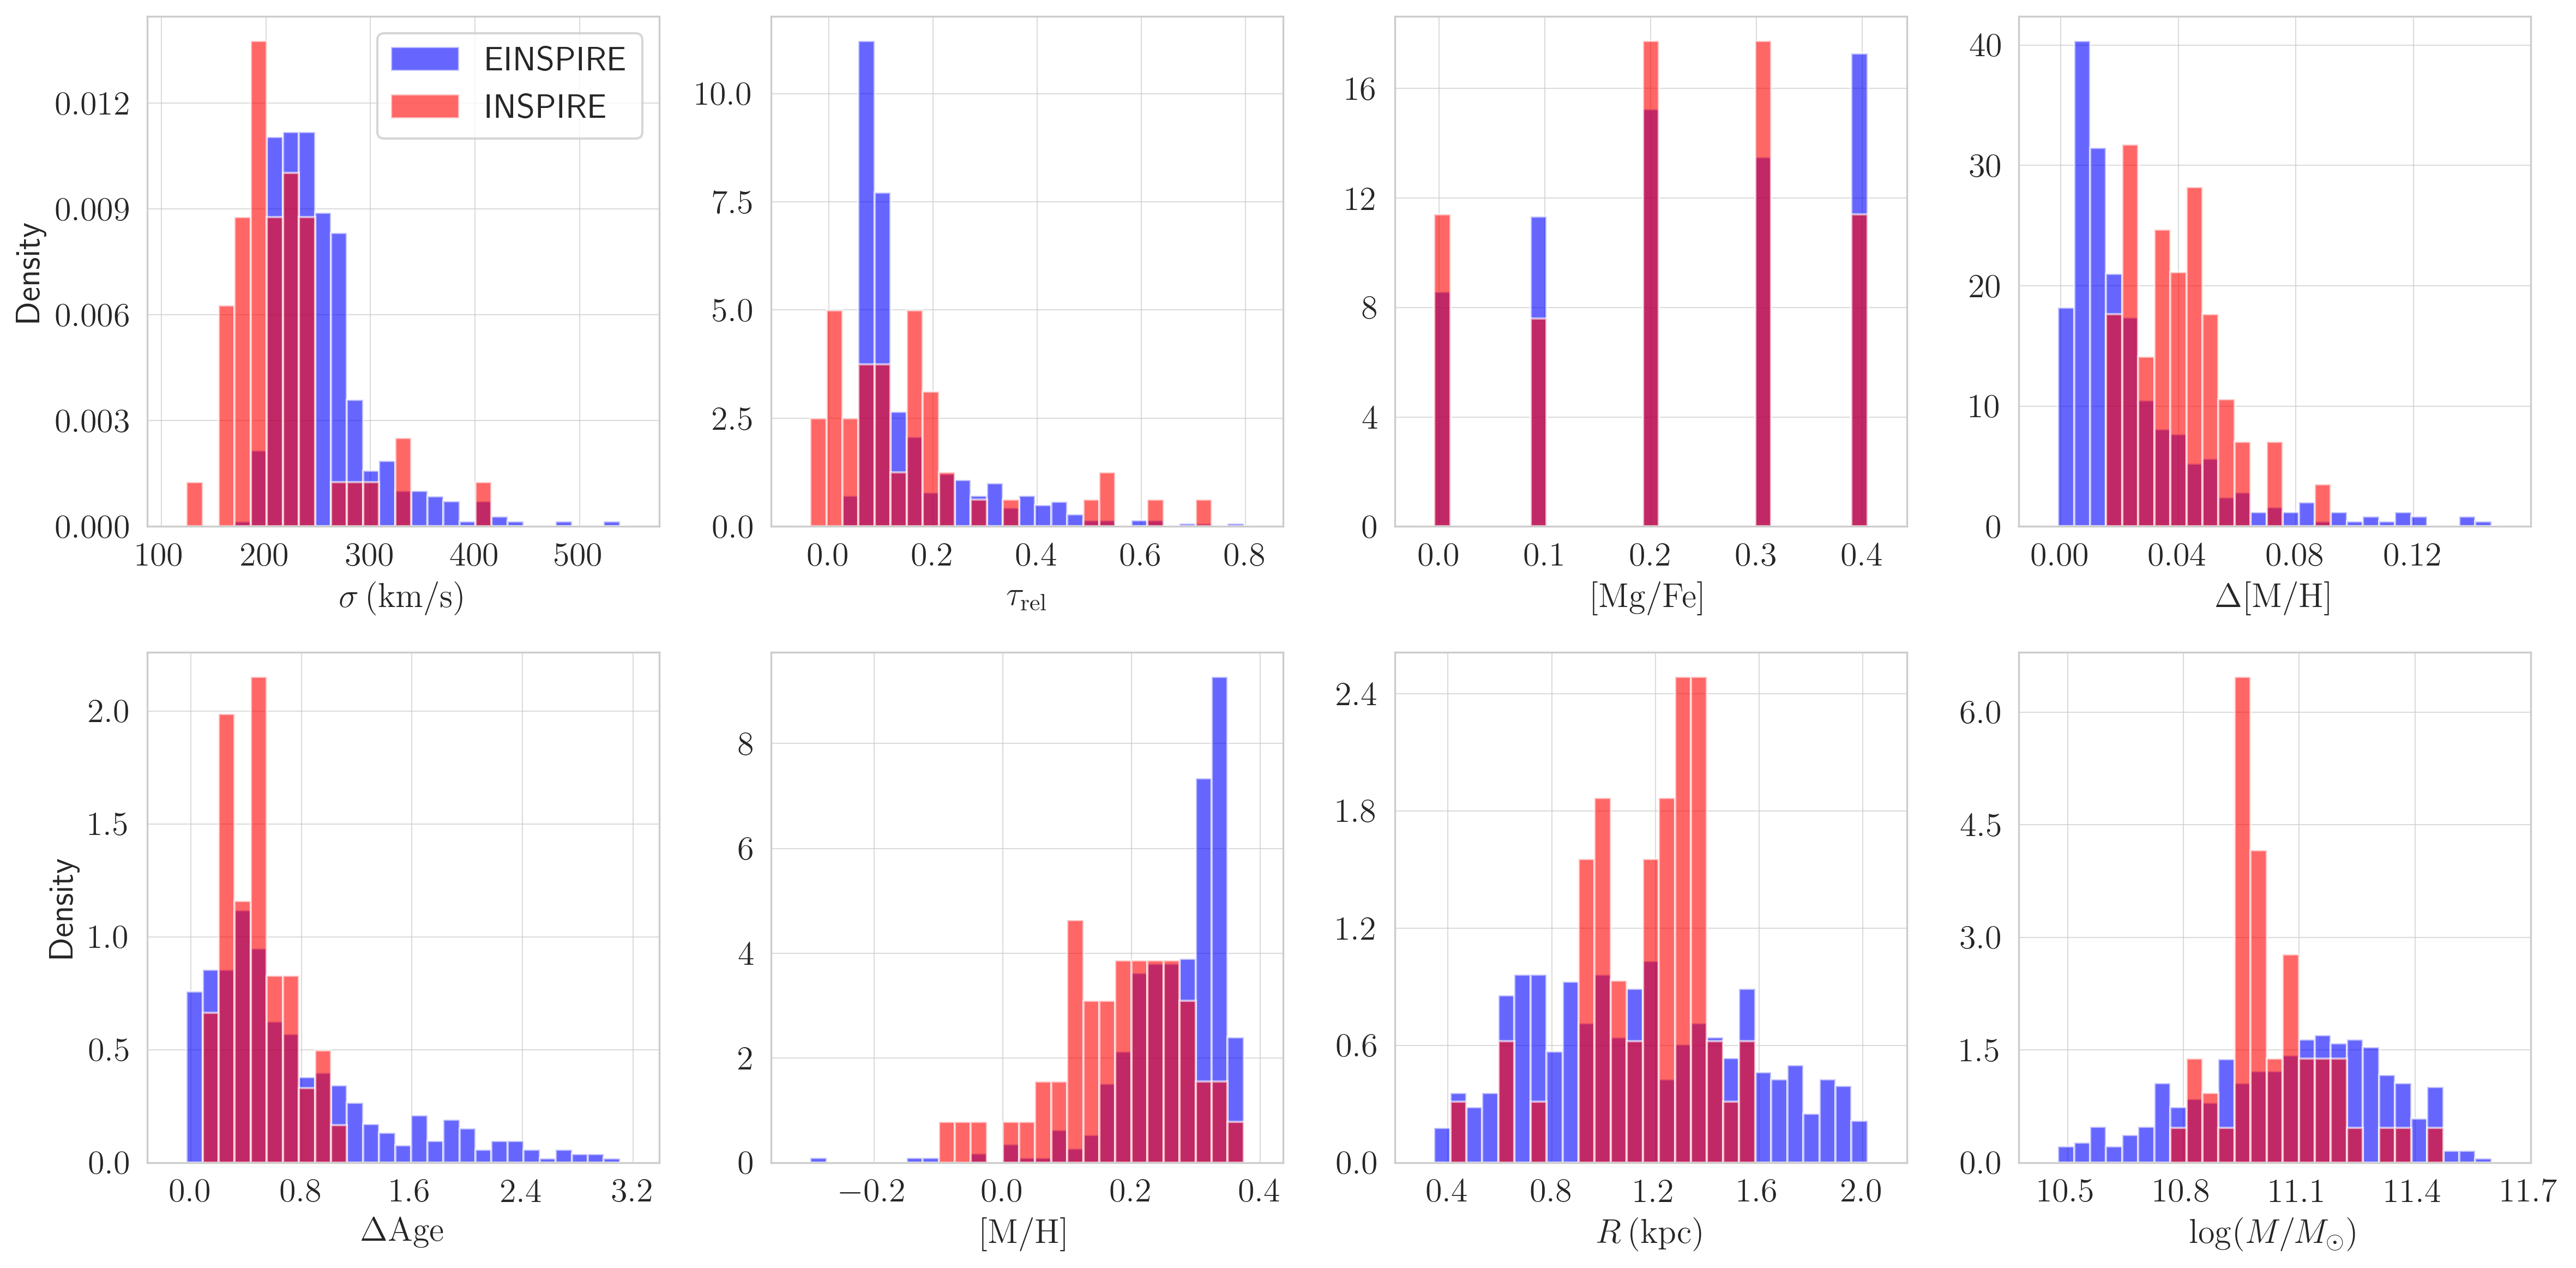

Feature Distribution Comparison Summary:
--------------------------------------------------------------------------------
Feature                Train Mean    Test Mean Scale Factor    Train Std     Test Std
--------------------------------------------------------------------------------
vdisp                    253.4504     214.0385         0.84      47.6529      48.1236
tau                        0.1559       0.1481         0.95       0.1237       0.1657
MgFe                       0.2297       0.2154         0.94       0.1364       0.1334
met_err                    0.0244       0.0398         1.63       0.0244       0.0154
lin_age_err                0.7350       0.4912         0.67       0.6453       0.2285
met                        0.2691       0.1800         0.67       0.0807       0.1013
rad_kpc                    1.1395       1.1670         1.02       0.4111       0.2366
logM                      11.0755      11.0296         1.00       0.2391       0.1347
DoR                    

In [50]:
plot_histograms=True
if plot_histograms:
    
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    from scipy.stats import entropy
    
    # Function to calculate JS divergence
    def js_divergence(p, q):
        """Calculate Jensen-Shannon divergence between two distributions."""
        # Create histograms with the same bins
        bins = np.linspace(min(np.min(p), np.min(q)), max(np.max(p), np.max(q)), 50)
        p_hist, _ = np.histogram(p, bins=bins, density=True)
        q_hist, _ = np.histogram(q, bins=bins, density=True)
        
        # Add small epsilon to avoid division by zero
        p_hist = p_hist + 1e-10
        q_hist = q_hist + 1e-10
        
        # Normalize
        p_hist = p_hist / np.sum(p_hist)
        q_hist = q_hist / np.sum(q_hist)
        
        # Calculate the midpoint distribution
        m = 0.5 * (p_hist + q_hist)
        
        # Calculate JS divergence using KL divergence
        return 0.5 * (entropy(p_hist, m) + entropy(q_hist, m))
    
    # Set LaTeX rendering for text
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "Computer Modern",
        "figure.dpi": 300,
        "font.size": 15,
    })
    
    # Dictionary to map feature names to nicer display names
    feature_names = {
        'met': r'$\mathrm{[M/H]}$',
        'tau': r'$\mathrm{\tau_{\rm rel}}$',
        'met_err': r'$\Delta{\mathrm{[M/H]}}$',
        'lin_age_err': r'$\Delta{\mathrm{Age}}$',
        'logM': r'$\log(M/M_{\odot})$',
        'rad_kpc': r'$R \, \mathrm{(kpc)}$',
        'MgFe': r'$\mathrm{[Mg/Fe]}$',
        'vdisp': r'$\sigma \, \mathrm{(km/s)}$',
        'DoR':'DoR'
    }
    
    # Store JS divergences
    js_divergences = {}
    
    # Default to original name if not in dictionary
    def get_display_name(feature):
        return feature_names.get(feature, feature)
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()  
    
    sns.set_style("whitegrid")
    for i, feature in enumerate(columns):
        if i >= len(axes):  # Skip if we run out of subplots
            break
            
        ax = axes[i]
        
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))  # 5 major ticks on x-axis
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))  # 5 major ticks on y-axis
        ax.grid(True, linestyle='-', linewidth=0.5, alpha=0.7)

        min_val = min(train_df[feature].min(), test_df[feature].min())
        max_val = max(train_df[feature].max(), test_df[feature].max())
        
        bins = np.linspace(min_val - 0.05 * (max_val - min_val), 
                           max_val + 0.05 * (max_val - min_val), 
                           30)
        
        # Plot histograms
        ax.hist(train_df[feature], bins=bins, alpha=0.6, label='EINSPIRE', density=True, color='blue')
        ax.hist(test_df[feature], bins=bins, alpha=0.6, label='INSPIRE', density=True, color='red')

        # Calculate JS divergence
        train_values = train_df[feature].dropna().values
        test_values = test_df[feature].dropna().values
        js_div = js_divergence(train_values, test_values)
        js_divergences[feature] = js_div
        
        # Add JS divergence text to plot
        js_text = f"JS Score = {js_div:.3f}"
        # ax.text(0.05, 0.95, js_text, transform=ax.transAxes, verticalalignment='top', fontsize=12,bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        
        train_mean = train_df[feature].mean()
        train_std = train_df[feature].std()
        test_mean = test_df[feature].mean()
        test_std = test_df[feature].std()
        
        """stats_text = f"Train: $\\mu={train_mean:.2f}$, $\\sigma={train_std:.2f}$\nTest: $\\mu={test_mean:.2f}$, $\\sigma={test_std:.2f}$"
        ax.text(0.95, 0.95, stats_text, 
                transform=ax.transAxes, 
                verticalalignment='top', 
                horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        if abs(train_mean) > 1e-6 and abs(test_mean) > 1e-6:
            scale_factor = test_mean / train_mean
            ax.text(0.95, 0.75, f"$\\frac{{\\mu_{{test}}}}{{\\mu_{{train}}}}$: {scale_factor:.2f}$\\times$", 
                    transform=ax.transAxes, 
                    verticalalignment='top', 
                    horizontalalignment='right',
                    bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))"""
        
        # Add titles and labels using the display name dictionary
        # ax.set_title(f"Distribution of {get_display_name(feature)}")
        ax.set_xlabel(get_display_name(feature))
        if i==0 or i==4:
            ax.set_ylabel("Density")
        if i==0:
            ax.legend()
    
    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.savefig("tests/train_test_histo.pdf", dpi=300)
    plt.show()
    
    print("Feature Distribution Comparison Summary:")
    print("-" * 80)
    print(f"{'Feature':<20} {'Train Mean':>12} {'Test Mean':>12} {'Scale Factor':>12} {'Train Std':>12} {'Test Std':>12}")
    print("-" * 80)
    
    for feature in columns:
        train_mean = train_df[feature].mean()
        train_std = train_df[feature].std()
        test_mean = test_df[feature].mean()
        test_std = test_df[feature].std()
        
        scale_factor = test_mean / train_mean if abs(train_mean) > 1e-6 else "N/A"
        if isinstance(scale_factor, float):
            scale_factor = f"{scale_factor:.2f}"
        print(f"{feature:<20} {train_mean:>12.4f} {test_mean:>12.4f} {scale_factor:>12} {train_std:>12.4f} {test_std:>12.4f}")
    
    # Print JS divergence summary
    print("\nJS Divergence Summary (sorted):")
    print("-" * 50)
    for feature, div in sorted(js_divergences.items(), key=lambda x: x[1], reverse=True):
        print(f"{feature:<20} JS Divergence: {div:.4f}")

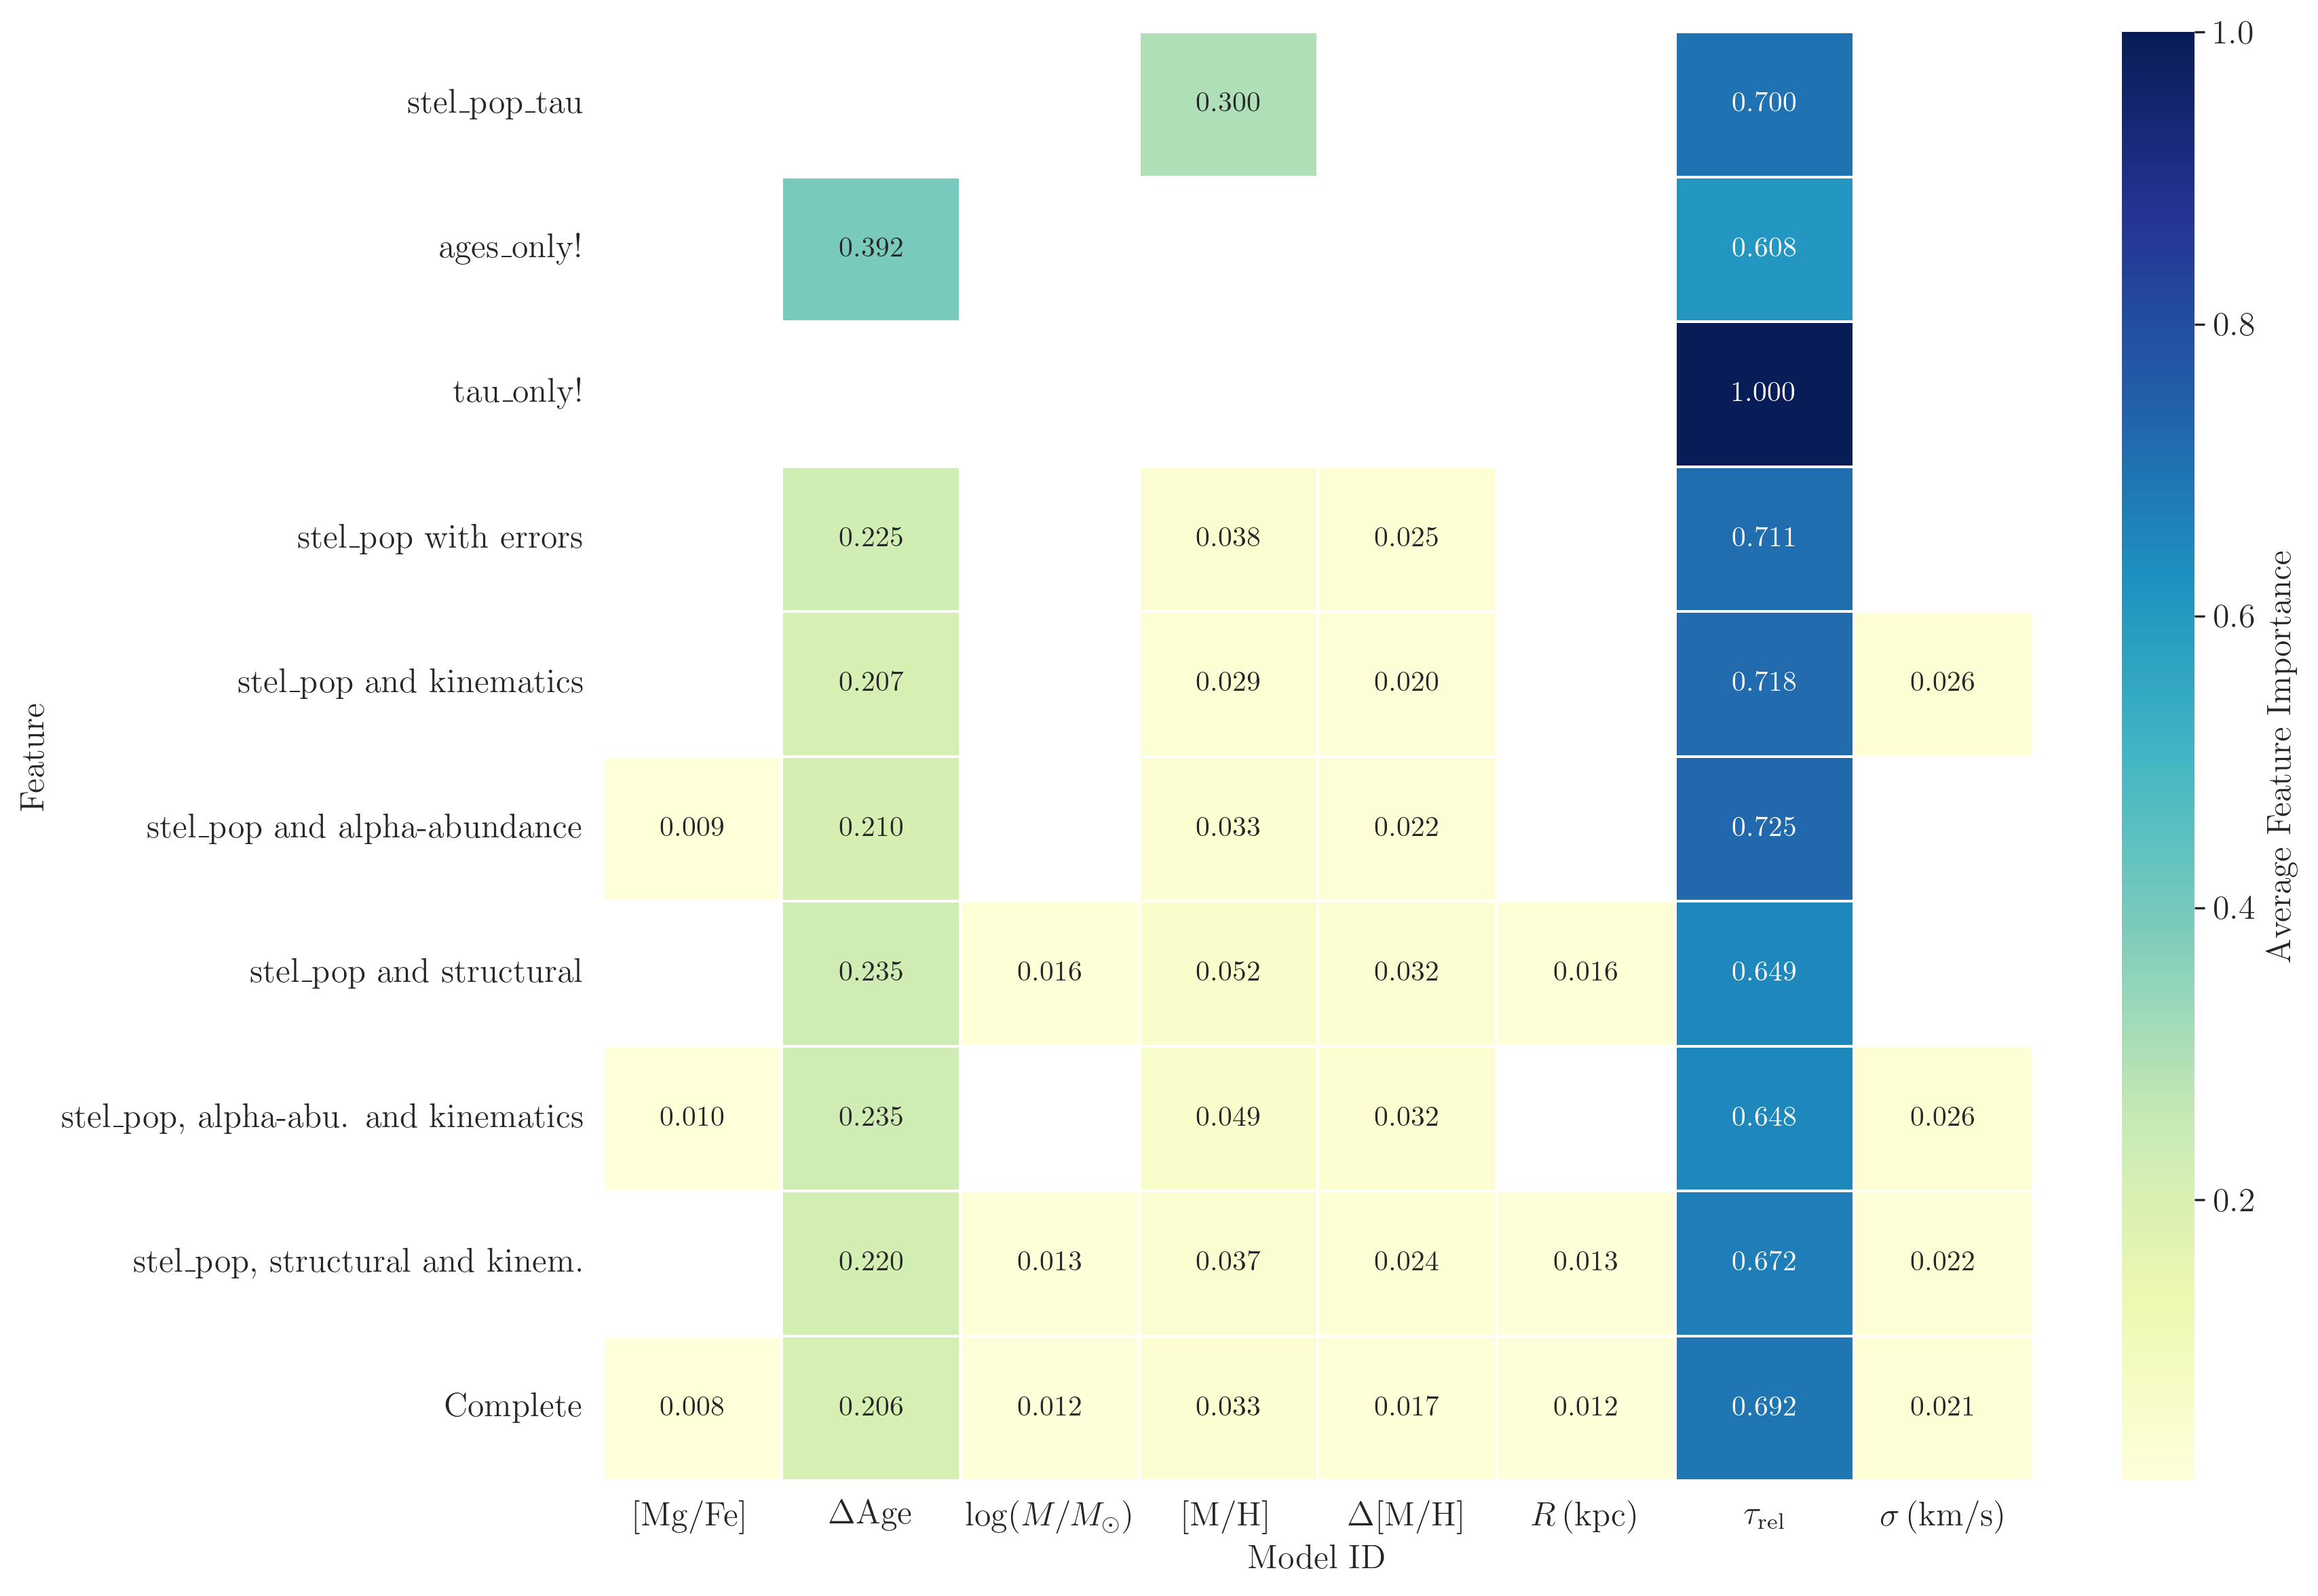

In [51]:
def plot_feature_importances():
    feature_names = {
        'met': r'$\mathrm{[M/H]}$',
        'tau': r'$\mathrm{\tau_{\rm rel}}$',
        'met_err': r'$\Delta{\mathrm{[M/H]}}$',
        'lin_age_err': r'$\Delta{\mathrm{Age}}$',
        'logM': r'$\log(M/M_{\odot})$',
        'rad_kpc': r'$R \, \mathrm{(kpc)}$',
        'MgFe': r'$\mathrm{[Mg/Fe]}$',
        'vdisp': r'$\sigma \, \mathrm{(km/s)}$',
        'DoR':'DoR'
    }
    # Create a DataFrame to store all feature importances
    all_importances = []

    # Group by model name to get unique models
    unique_models = results_summary['name'].unique()
    
    # For each unique model, calculate the average importance of each feature
    for model_name in unique_models:
        # Get all rows for this model
        model_rows = results_summary[results_summary['name'] == model_name]
        
        # Initialize a dictionary to store the sum of importances for each feature
        feature_sums = {}
        feature_counts = {}
        
        # Sum up the importances for each feature across all runs of this model
        for _, row in model_rows.iterrows():
            importances = row['feature_importances']
            
            if importances is not None:
                for feature, importance in importances.items():
                    if feature not in feature_sums:
                        feature_sums[feature] = 0
                        feature_counts[feature] = 0
                    
                    feature_sums[feature] += importance
                    feature_counts[feature] += 1
        
        # Calculate the average importance for each feature
        avg_importances = {feature: feature_sums[feature] / feature_counts[feature] 
                          for feature in feature_sums}
        
        # Add to the results
        for feature, avg_importance in avg_importances.items():
            all_importances.append({
                'Model': model_name,
                'Feature': feature,
                'Importance': avg_importance
            })

    # Convert to DataFrame
    importance_df = pd.DataFrame(all_importances)

    # Create feature category mapping
    feature_categories = {
        'met': 'Stellar Population',
        'tau': 'Stellar Population',
        'met_err': 'Measurement Error',
        'lin_age_err': 'Measurement Error',
        'vdisp': 'Kinematics',
        'MgFe': 'Chemical Composition',
        'logM': 'Structure',
        'rad_kpc': 'Structure',
        'DoR': 'Structure'
    }

    # Add category column
    importance_df['Category'] = importance_df['Feature'].map(feature_categories)

    # Set plot style
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "Computer Modern",
        "figure.dpi": 300,
        "font.size": 12,
    })

    # Create pivot table with actual NaN values for missing features (not 0s)
    pivot_df = importance_df.pivot_table(
        index='Model',
        columns='Feature',
        values='Importance',
        aggfunc='mean'
    )  # Remove fillna(0) to keep NaN values

    # Sort rows to match the order of unique_models
    pivot_df = pivot_df.reindex(unique_models)

    # Rename columns using the feature_names dictionary
    pivot_df = pivot_df.rename(columns=feature_names)

    # Create mask for NaN values AFTER renaming columns
    mask = pivot_df.isna()

    # Custom function to format annotations
    def format_val(val):
        return "{:.3f}".format(val) if not np.isnan(val) else ""
    
    # Create annotations array with formatted values
    annotations = np.vectorize(format_val)(pivot_df.values)

    # Create heatmap
    plt.figure(figsize=(12, 8))
    ax = sns.heatmap(
        pivot_df,
        annot=annotations,  # Use pre-formatted annotation array
        cmap='YlGnBu',
        fmt='',  # Empty format string since we're using pre-formatted annotations
        linewidths=0.5,
        cbar_kws={'label': 'Average Feature Importance'},
        annot_kws={"size": 10},
        mask=mask  # Apply mask for NaN values
    )
    
    #ax.set_ylabel("Model ID")
    ax.set_xlabel("Model ID")
    ax.set_ylabel("Feature")

    plt.tight_layout()
    plt.savefig('tests/avg_feature_imp_map.pdf', bbox_inches='tight')

    # Save the importance data to CSV with proper feature names
    # Create a copy of importance_df with renamed features
    export_df = importance_df.copy()
    export_df['Feature'] = export_df['Feature'].map(feature_names).fillna(export_df['Feature'])
    # export_df.to_csv('tests/avg_feature_importances.csv', index=False)

    return importance_df

plot_fi = True
if plot_fi:
    importance_data = plot_feature_importances()

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap


def create_corner_plots(df, features, feature_display_names=None, target='DoR', target_display_name=None):

    # Set LaTeX style to match the original code
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "Computer Modern",
        "figure.dpi": 300,
        "font.size": 15,
    })
    
    # Create display names dictionary if not provided
    if feature_display_names is None:
        feature_display_names = {f: f for f in features}
    
    # Set target display name if not provided
    if target_display_name is None:
        target_display_name = target
    
    # Create the first version with the target included as a feature
    # plot_features_with_target(df, features, feature_display_names, target, target_display_name)
    
    # Create the second version without the target but colored by the target
    plot_features_colored_by_target(df, features, feature_display_names, target, target_display_name)

def plot_features_with_target(df, features, feature_display_names, target='DoR', target_display_name=None):
    """Create a corner plot with all features including the target"""
    # Create a new figure
    fig = plt.figure(figsize=(16, 16))
    
    # If target display name not provided, use the target name
    if target_display_name is None:
        target_display_name = target
    
    # Include target in the feature list for this plot
    all_vars = features.copy()
    all_display_names = feature_display_names.copy()
    
    if target not in all_vars:
        all_vars.append(target)
        all_display_names[target] = target_display_name
    
    # Number of variables
    n_vars = len(all_vars)
    
    # Create subplots for each pair of variables
    for i in range(n_vars):
        for j in range(n_vars):
            # Create subplot
            ax = fig.add_subplot(n_vars, n_vars, i * n_vars + j + 1)
            
            if i == j:  # Diagonal: histogram
                # Draw the histogram
                sns.histplot(df[all_vars[i]], kde=True, ax=ax, color='steelblue', 
                            edgecolor='black', linewidth=0.8, alpha=0.7)
                
                # Remove title
                ax.set_title("")
                
                # Add "Count" as a title above the plot instead of as a y-label
                # ax.set_title("Count", fontsize=14, pad=10)
                
                # Remove x-label for diagonal histograms
                ax.set_xlabel("")
                
                # Only set x-label for the bottom row
                if i == n_vars - 1:
                    ax.set_xlabel(all_display_names[all_vars[i]], fontsize=16)
                
                # Remove y-label but keep y-tick labels
                ax.set_ylabel("")
                # Rotate y-ticks 45 degrees for better readability
                ax.tick_params(axis='y', rotation=45)
                
                # If not the bottom row, hide x-tick labels
                if i < n_vars - 1:
                    ax.set_xticklabels([])
                
                ax.grid(True, alpha=0.3)
            
            elif i > j:  # Lower triangle: scatter plots
                scatter = ax.scatter(df[all_vars[j]], df[all_vars[i]], 
                                    s=30, alpha=0.6, 
                                    edgecolors='k', linewidths=0.5)
                
                # Add grid
                ax.grid(True, alpha=0.3)
                
                # Set axis labels only for the bottom row and leftmost column
                # Use display names for labels
                if i == n_vars - 1:
                    ax.set_xlabel(all_display_names[all_vars[j]], fontsize=16)
                else:
                    ax.set_xlabel('')
                    
                if j == 0:
                    ax.set_ylabel(all_display_names[all_vars[i]], fontsize=16)
                else:
                    ax.set_ylabel('')
                
                # Only show tick labels on the edges
                if i < n_vars - 1:  # Not the bottom row
                    ax.set_xticklabels([])
                if j > 0:  # Not the leftmost column
                    ax.set_yticklabels([])
            
            else:  # Upper triangle: leave empty
                ax.axis('off')
            
            # Set ticks inward
            if i != j and i > j:
                ax.tick_params(axis='both', which='both', direction='in', labelsize=12)
                ax.minorticks_on()
    
    # Use larger wspace to increase horizontal spacing between subplots
    plt.tight_layout()
    fig.subplots_adjust(wspace=0.3, hspace=0.1)
    plt.savefig(f'tests/corner_plain.pdf')
    
    return fig

def plot_features_colored_by_target(df, features, feature_display_names, target='DoR', target_display_name=None):
    """Create a corner plot with features colored by the target variable"""
    # Create a new figure
    fig = plt.figure(figsize=(16, 16))
    
    # If target display name not provided, use the target name
    if target_display_name is None:
        target_display_name = target
    
    # Number of variables
    n_vars = len(features)
    
    # Create a custom colormap with red for high values (inverted heat colors)
    colors = ["navy", "blue", "dodgerblue", "deepskyblue", "cyan", 
              "yellowgreen", "yellow", "gold", "orange", "orangered", "red", "darkred"]
    cmap = LinearSegmentedColormap.from_list("DoR_cmap", colors) 
    
    # Normalize the target variable for coloring
    norm = plt.Normalize(df[target].min(), df[target].max())
    
    # Create subplots for each pair of variables
    for i in range(n_vars):
        for j in range(n_vars):
            # Create subplot
            ax = fig.add_subplot(n_vars, n_vars, i * n_vars + j + 1)
            
            if i == j:  # Diagonal: histogram

                if features[i] == 'MgFe':
                    mgfe_values = [0.0, 0.1, 0.2, 0.3, 0.4]
                    
                    mgfe_custom_bins = []
                    for value in mgfe_values:
                        mgfe_custom_bins.append(value - 0.005)  # Small buffer below the value
                        mgfe_custom_bins.append(value + 0.005)  # Small buffer above the value
                    
                    mgfe_custom_bins.append(0.405)
                    
                    #mgfe_custom_bins = [max(0, bin_edge) for bin_edge in mgfe_custom_bins]
                    #mgfe_custom_bins = sorted(list(set(mgfe_custom_bins)))
                    
                    counts, bins, patches = ax.hist(df[features[i]], bins=mgfe_custom_bins, alpha=0.7, linewidth=0.8)
                else:
                    counts, bins, patches = ax.hist(df[features[i]], bins=40, alpha=0.7, linewidth=0.8)
                
                
                
                """
                bin_centers = 0.5 * (bins[:-1] + bins[1:])
                for count, x, patch in zip(counts, bin_centers, patches):
                    # Find indices of points in this bin
                    bin_mask = (df[features[i]] >= x - (bins[1]-bins[0])/2) & \
                              (df[features[i]] < x + (bins[1]-bins[0])/2)
                    
                    if any(bin_mask):
                        # Color by average DoR in this bin
                        avg_DoR = df.loc[bin_mask, target].mean()
                        patch.set_facecolor(cmap(norm(avg_DoR)))
                    else:
                        patch.set_facecolor('gray')"""
                    
                for idx, (patch, left_edge, right_edge) in enumerate(zip(patches, bins[:-1], bins[1:])):
                    # For the last bin, include the right edge
                    if idx == len(patches) - 1:
                        bin_mask = (df[features[i]] >= left_edge) & (df[features[i]] <= right_edge)
                    else:
                        bin_mask = (df[features[i]] >= left_edge) & (df[features[i]] < right_edge)
                    
                    if any(bin_mask):
                        avg_DoR = df.loc[bin_mask, target].mean()
                        patch.set_facecolor(cmap(norm(avg_DoR)))
                    else:
                        patch.set_facecolor('gray')
                
                # Add "Count" as a title above the plot instead of as a y-label
                # ax.set_title("Count", fontsize=14, pad=10)
                
                # Remove x-label for diagonal histograms
                ax.set_xlabel("")
                
                # Only set x-label for the bottom row
                if i == n_vars - 1:
                    ax.set_xlabel(feature_display_names[features[i]], fontsize=16)
                
                # Remove y-label but keep y-tick labels
                ax.set_ylabel("")
                # Rotate y-ticks 45 degrees for better readability
                # ax.tick_params(axis='y', rotation=45)
                ax.set_yticklabels([])

                
                # If not the bottom row, hide x-tick labels
                if i < n_vars - 1:
                    ax.set_xticklabels([])
                
                ax.grid(True, alpha=0.3)
            
            elif i > j:  # Lower triangle: scatter plots colored by target
                scatter = ax.scatter(df[features[j]], df[features[i]], 
                                    c=df[target], cmap=cmap, 
                                    s=30, alpha=0.7, linewidths=0.5)
                
                # Add grid
                ax.grid(True, alpha=0.3)
                
                # Set axis labels only for the bottom row and leftmost column
                # Use display names for labels
                if i == n_vars - 1:
                    ax.set_xlabel(feature_display_names[features[j]], fontsize=16)
                else:
                    ax.set_xlabel('')
                    
                if j == 0:
                    ax.set_ylabel(feature_display_names[features[i]], fontsize=16)
                else:
                    ax.set_ylabel('')
                
                # Only show tick labels on the edges
                if i < n_vars - 1:  # Not the bottom row
                    ax.set_xticklabels([])
                if j > 0:  # Not the leftmost column
                    ax.set_yticklabels([])
            
            else:  # Upper triangle: leave empty
                ax.axis('off')
            
            # Set ticks inward
            if i != j and i > j:
                ax.tick_params(axis='both', which='both', direction='in', labelsize=12)
                ax.minorticks_on()
    
    # Add colorbar to the right of the plot
    cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
    cbar.set_label(target_display_name, rotation=270, fontsize=20, labelpad=20)
    cbar_ax.tick_params(labelsize=12)
    
    # Use larger wspace to increase horizontal spacing between subplots
    plt.tight_layout()
    fig.subplots_adjust(wspace=0.1, hspace=0.1, right=0.9)
    
    plt.savefig(f'tests/corner_dor_coloured.pdf')
    
    return fig

corner = False
if corner:
    target = 'DoR'
    FEATURES = ['met', 'tau', 'met_err', 'lin_age_err', 'logM', 'rad_kpc', 'MgFe', 'vdisp', 'DoR'] # , 'vdisp_err']
    
    # Set a display name for the target variable
    TARGET_DISPLAY_NAME = r'$\mathrm{DoR}$'  # Degree of Rotation
        
    # Create both types of corner plots with custom display names
    create_corner_plots(
        test_df, 
        FEATURES, 
        target=target,
        target_display_name=TARGET_DISPLAY_NAME
    )
    
    create_corner_plots(
        train_df, 
        FEATURES, 
        target=target,
        target_display_name=TARGET_DISPLAY_NAME
    )

In [53]:
def plot_features_by_dataset(train_df, test_df, features, feature_display_names=None):
    
    # Set LaTeX style to match the original code
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "Computer Modern",
        "figure.dpi": 300,
        "font.size": 15,
    })
    
    # Create display names dictionary if not provided
    if feature_display_names is None:
        feature_display_names = {f: f for f in features}
    
    # Create a new figure
    fig = plt.figure(figsize=(16, 16))
    
    # Number of variables
    n_vars = len(features)
    
    # Combine datasets with an identifier column
    train_df_copy = train_df.copy()
    test_df_copy = test_df.copy()
    
    train_df_copy['dataset'] = 'EINSPIRE'
    test_df_copy['dataset'] = 'INSPIRE'
    
    # Combine both datasets
    combined_df = pd.concat([train_df_copy, test_df_copy], ignore_index=True)
    
    # Define colors for each dataset
    dataset_colors = {'EINSPIRE': 'blue', 'INSPIRE': 'red'}
    
    # Create subplots for each pair of variables
    for i in range(n_vars):
        for j in range(n_vars):
            # Create subplot
            ax = fig.add_subplot(n_vars, n_vars, i * n_vars + j + 1)
            
            if i == j:  # Diagonal: histogram
                # Plot histograms for both datasets
                for dataset, color in dataset_colors.items():
                    subset = combined_df[combined_df['dataset'] == dataset]
                    
                    # Special handling for MgFe if it exists
                    if features[i] == 'MgFe':
                        mgfe_values = [0.0, 0.1, 0.2, 0.3, 0.4]
                        mgfe_custom_bins = []
                        for value in mgfe_values:
                            mgfe_custom_bins.append(value - 0.005)
                            mgfe_custom_bins.append(value + 0.005)
                        mgfe_custom_bins.append(0.405)
                        bins = mgfe_custom_bins
                    else:
                        bins = 40
                    
                    # Use histtype='step' for clearer overlapping histograms
                    ax.hist(subset[features[i]], bins=bins, alpha=0.5, 
                            color=color, label=dataset, edgecolor='black', 
                            linewidth=0.8, density=True)
                
                # Remove x-label for diagonal histograms
                ax.set_xlabel("")
                
                # Only set x-label for the bottom row
                if i == n_vars - 1:
                    ax.set_xlabel(feature_display_names[features[i]], fontsize=16)
                
                # Remove y-label but keep y-tick labels
                ax.set_ylabel("")
                ax.set_yticklabels([])
                
                # If not the bottom row, hide x-tick labels
                if i < n_vars - 1:
                    ax.set_xticklabels([])
                
                # Add legend only for the first diagonal plot
                if i == 0:
                    ax.legend(fontsize=10)
                
                ax.grid(True, alpha=0.3)
            
            elif i > j:  # Lower triangle: scatter plots colored by dataset
                # Plot scatter for both datasets
                for dataset, color in dataset_colors.items():
                    subset = combined_df[combined_df['dataset'] == dataset]
                    ax.scatter(subset[features[j]], subset[features[i]], 
                                c=color, label=dataset, 
                                s=30, alpha=0.6, 
                                edgecolors='k', linewidths=0.5)
                
                # Add grid
                ax.grid(True, alpha=0.3)
                
                # Set axis labels only for the bottom row and leftmost column
                if i == n_vars - 1:
                    ax.set_xlabel(feature_display_names[features[j]], fontsize=16)
                else:
                    ax.set_xlabel('')
                    
                if j == 0:
                    ax.set_ylabel(feature_display_names[features[i]], fontsize=16)
                else:
                    ax.set_ylabel('')
                
                # Only show tick labels on the edges
                if i < n_vars - 1:  # Not the bottom row
                    ax.set_xticklabels([])
                if j > 0:  # Not the leftmost column
                    ax.set_yticklabels([])
            
            else:  # Upper triangle: leave empty
                ax.axis('off')
            
            # Set ticks inward
            if i != j and i > j:
                ax.tick_params(axis='both', which='both', direction='in', labelsize=12)
                ax.minorticks_on()
    
    # Use larger wspace to increase horizontal spacing between subplots
    plt.tight_layout()
    fig.subplots_adjust(wspace=0.1, hspace=0.1)
    
    plt.savefig('tests/corner_train_test_comparison.pdf')
    
    return fig

corner_2 = False
if corner_2:
    FEATURES = ['met', 'tau', 'met_err', 'lin_age_err', 'logM', 'rad_kpc', 'MgFe', 'vdisp', 'DoR'] 
    
    FEATURE_DISPLAY_NAMES = {
        'met': r'$\mathrm{[M/H]}$',
        'tau': r'$\mathrm{\tau_{\rm rel}}$',
        'met_err': r'$\Delta{\mathrm{[M/H]}}$',
        'lin_age_err': r'$\Delta{\mathrm{Age}}$',
        'logM': r'$\log(M/M_{\odot})$',
        'rad_kpc': r'$R \, \mathrm{(kpc)}$',
        'MgFe': r'$\mathrm{[Mg/Fe]}$',
        'vdisp': r'$\sigma \, \mathrm{(km/s)}$',
        'DoR':'DoR'
    }
    
    # Call the new function
    plot_features_by_dataset(
        train_df, 
        test_df, 
        FEATURES, 
        feature_display_names=FEATURE_DISPLAY_NAMES
    )

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

# Set plot style for scientific visualization
plt.rcParams.update({
    "text.usetex": False,  # No LaTeX
    "font.family": "sans-serif",
    "figure.dpi": 300,
    "font.size": 14,
})

def perform_residual_analysis(train_df, test_df, features, target='DoR', model_params=None):
    if model_params is None:
        model_params = {
            'max_depth': 13,
            'max_features': 0.8,
            'max_samples': 0.7,
            'min_samples_leaf': 3,
            'min_samples_split': 5,
            'n_estimators': 60,
            'random_state': 42
        }
    
    # Extract features and target
    X_train = train_df[features]
    y_train = train_df[target]
    X_test = test_df[features]
    y_test = test_df[target]
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train the model
    print("Training random forest model...")
    rf_model = RandomForestRegressor(**model_params)
    rf_model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_train_pred = rf_model.predict(X_train_scaled)
    y_test_pred = rf_model.predict(X_test_scaled)
    
    # Calculate residuals
    train_residuals = y_train - y_train_pred
    test_residuals = y_test - y_test_pred
    
    # Calculate metrics
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    print(f"Train R2: {train_r2:.4f}, RMSE: {train_rmse:.4f}")
    print(f"Test R2: {test_r2:.4f}, RMSE: {test_rmse:.4f}")
    
    # Store results
    results = {
        'model': rf_model,
        'train_predictions': y_train_pred,
        'test_predictions': y_test_pred,
        'train_residuals': train_residuals,
        'test_residuals': test_residuals,
        'feature_importances': dict(zip(features, rf_model.feature_importances_)),
        'metrics': {
            'train_r2': train_r2,
            'test_r2': test_r2,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse
        }
    }
    
    return results

def plot_residuals_by_feature(test_df, features, results, output_dir='./residual_plots'):

    import os
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Create a custom colormap
    colors = ["navy", "blue", "dodgerblue", "deepskyblue", "cyan", 
              "yellowgreen", "yellow", "gold", "orange", "orangered", "red", "darkred"]
    cmap = LinearSegmentedColormap.from_list("residual_cmap", colors)
    
    # Plot residuals against each feature
    for feature in features:
        plt.figure(figsize=(10, 6))
        
        # Scatter plot with coloring by absolute residual magnitude
        scatter = plt.scatter(
            test_df[feature],
            results['test_residuals'],
            c=np.abs(results['test_residuals']),
            cmap=cmap,
            alpha=0.7,
            s=40,
            edgecolors='k',
            linewidths=0.5
        )
        
        # Add horizontal line at y=0
        plt.axhline(y=0, color='black', linestyle='--', alpha=0.7)
        
        # Add trend line to highlight patterns
        try:
            z = np.polyfit(test_df[feature], results['test_residuals'], 1)
            p = np.poly1d(z)
            plt.plot(
                np.sort(test_df[feature].values),
                p(np.sort(test_df[feature].values)),
                "r--", 
                linewidth=2,
                alpha=0.7
            )
            
            # Calculate correlation coefficient
            corr = np.corrcoef(test_df[feature], results['test_residuals'])[0, 1]
            plt.annotate(
                f"Correlation: {corr:.3f}",
                xy=(0.05, 0.95),
                xycoords='axes fraction',
                fontsize=12,
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
            )
        except:
            print(f"Could not calculate trend line for {feature}")
        
        # Add colorbar
        cbar = plt.colorbar(scatter)
        cbar.set_label('Absolute Residual', rotation=270, labelpad=20)
        
        # Set labels and title
        plt.xlabel(feature)
        plt.ylabel('Residual (True - Predicted)')
        plt.title(f'Residuals vs {feature}')
        plt.grid(alpha=0.3)
        
        # Save the plot
        plt.tight_layout()
        #plt.savefig(f"{output_dir}/residual_{feature}.pdf")
        plt.close()
    
    print(f"Individual residual plots saved to {output_dir}")

def create_feature_residual_grid(test_df, features, results, output_dir='./residual_plots'):    
    import os
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Calculate number of rows and columns for the grid
    n_features = len(features)
    n_cols = min(3, n_features)
    n_rows = int(np.ceil(n_features / n_cols))
    
    # Create the figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
    axes = axes.flatten() if n_features > 1 else [axes]
    
    # Plot for each feature
    for i, feature in enumerate(features):
        ax = axes[i]
        
        # Scatter plot
        scatter = ax.scatter(
            test_df[feature],
            results['test_residuals'],
            c=np.abs(results['test_residuals']),
            cmap='viridis',
            alpha=0.7,
            s=30,
            edgecolors='none'
        )
        
        # Add horizontal line at y=0
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.7)
        
        # Add trend line
        try:
            z = np.polyfit(test_df[feature], results['test_residuals'], 1)
            p = np.poly1d(z)
            ax.plot(
                np.sort(test_df[feature].values),
                p(np.sort(test_df[feature].values)),
                "r--", 
                linewidth=1.5,
                alpha=0.7
            )
            
            # Calculate correlation coefficient
            corr = np.corrcoef(test_df[feature], results['test_residuals'])[0, 1]
            ax.annotate(
                f"Corr: {corr:.3f}",
                xy=(0.05, 0.95),
                xycoords='axes fraction',
                fontsize=10,
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="gray", alpha=0.8)
            )
        except:
            pass
        
        # Set labels
        ax.set_xlabel(feature)
        ax.set_ylabel('Residual')
        ax.set_title(f'Residuals vs {feature}')
        ax.grid(alpha=0.3)
    
    # Hide any extra axes
    for i in range(n_features, len(axes)):
        axes[i].set_visible(False)
    
    # Add a colorbar for the entire figure
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(scatter, cax=cbar_ax)
    cbar.set_label('Absolute Residual', rotation=270, labelpad=20)
    
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.savefig(f"{output_dir}/residual_grid.pdf")
    plt.close()
    
    print(f"Residual grid plot saved to {output_dir}")

def create_residual_analysis_report(train_df, test_df, features, target='DoR', model_params=None):

    print("Starting residual analysis...")
    
    # Step 1: Train model and compute residuals
    results = perform_residual_analysis(train_df, test_df, features, target, model_params)
    
    # Step 3: Plot residuals against each feature
    print("\nCreating individual residual plots...")
    plot_residuals_by_feature(test_df, features, results)
    
    # Step 4: Create grid of residual plots
    print("\nCreating residual grid plot...")
    create_feature_residual_grid(test_df, features, results)
    
    
    # Step 6: Sort features by residual correlation
    residual_correlations = {}
    for feature in features:
        corr = np.corrcoef(test_df[feature], results['test_residuals'])[0, 1]
        residual_correlations[feature] = corr
    
    sorted_correlations = sorted(
        residual_correlations.items(),
        key=lambda x: abs(x[1]),
        reverse=True
    )
    
    print("\nFeatures ranked by absolute correlation with residuals:")
    for feature, corr in sorted_correlations:
        print(f"{feature}: {corr:.4f}")

resids = False
if resids:
    
    # columns = ['vdisp','tau','MgFe', 'met_err', 'lin_age_err','met','rad_kpc','logM','DoR']# ,'logAge', 'lin_age',]
    columns = ['tau','met','DoR']
    #train_df, test_df = prepare_data(columns)
    
    # Define features to analyze
    features = ['tau','met'] #['met', 'tau', 'met_err', 'lin_age_err', 'logM', 'rad_kpc', 'MgFe', 'vdisp']
    
    # Optimized model parameters
    model_params = {
        'max_depth': 8,
        'max_features': 0.8,
        'max_samples': 0.7,
        'min_samples_leaf': 3,
        'min_samples_split': 5,
        'n_estimators': 50,
        'random_state': 42
    }
    
    # Perform analysis
    analysis_results = create_residual_analysis_report(train_df, test_df, features, 'DoR', model_params)
    # analysis_results = create_residual_analysis_report(train_df, train_df, features, 'DoR', model_params)


# Extra stuff: classification, residuals, models 

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold


def perform_cv_classification(df, FEATURES, threshold, MODEL_PARAMS, n_splits=5):

    # Create binary target variable
    df['DoR_class'] = (df['DoR'] >= threshold).astype(int)

    # Extract features and target
    X = df[FEATURES]
    y = df['DoR_class']

    # Set up K-Fold cross-validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=MODEL_PARAMS['random_state'])

    # Initialize metrics lists
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    feature_importance_sums = {feature: 0 for feature in FEATURES}

    # Perform k-fold cross-validation
    for train_idx, test_idx in kf.split(X):
        # Split data
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Train model
        rf_model = RandomForestClassifier(**MODEL_PARAMS)
        rf_model.fit(X_train_scaled, y_train)

        # Make predictions
        y_pred = rf_model.predict(X_test_scaled)

        # Calculate metrics
        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred, zero_division=0))
        recalls.append(recall_score(y_test, y_pred, zero_division=0))
        f1_scores.append(f1_score(y_test, y_pred, zero_division=0))

        # Accumulate feature importances
        for i, feature in enumerate(FEATURES):
            feature_importance_sums[feature] += rf_model.feature_importances_[i]

    # Calculate average feature importances
    feature_importances = {feature: value / n_splits for feature, value in feature_importance_sums.items()}

    # Calculate class distribution
    class_dist = {
        'percent_high': (y == 1).mean() * 100,
        'percent_low': (y == 0).mean() * 100
    }

    # Build results dictionary
    cv_results = {
        'threshold': threshold,
        'accuracy': np.mean(accuracies),
        'precision': np.mean(precisions),
        'recall': np.mean(recalls),
        'f1': np.mean(f1_scores),
        'feature_importances': feature_importances,
        'class_distribution': class_dist
    }

    return cv_results


def run_classification_analysis(thresholds, features=None):
    # Set default features if none provided
    if features is None:
        features = ['met', 'tau', 'met_err', 'lin_age_err', 'logM', 'rad_kpc', 'MgFe', 'vdisp']

    # Nice display names for features
    feature_display_names = {
        'met': r'$\mathrm{[M/H]}$',
        'tau': r'$\mathrm{\tau_{\rm rel}}$',
        'met_err': r'$\Delta{\mathrm{[M/H]}}$',
        'lin_age_err': r'$\Delta{\mathrm{Age}}$',
        'logM': r'$\log(M/M_{\odot})$',
        'rad_kpc': r'$R \, \mathrm{(kpc)}$',
        'MgFe': r'$\mathrm{[Mg/Fe]}$',
        'vdisp': r'$\sigma \, \mathrm{(km/s)}$'
    }

    # Model parameters
    MODEL_PARAMS = {
        'max_depth': 8,
        'max_features': 0.8,
        'criterion': 'gini',
        'min_samples_leaf': 3,
        'min_samples_split': 5,
        'n_estimators': 50,
        'random_state': 42
    }

    # Create directory for results if it doesn't exist
    import os
    if not os.path.exists('tests'):
        os.makedirs('tests')

    # Prepare data - only need train_df
    columns = ['vdisp', 'tau', 'MgFe', 'met_err', 'lin_age_err', 'met', 'rad_kpc', 'logM', 'DoR']
    train_df, _ = prepare_data(columns)

    # Initialize results containers
    cv_results_all = []
    feature_importance_by_threshold = {}

    # Run analysis for each threshold
    for threshold in thresholds:
        print(f"Running classification analysis for threshold: {threshold}")

        # Run cross-validation
        cv_result = perform_cv_classification(
            train_df,
            features,
            threshold,
            MODEL_PARAMS
        )
        cv_results_all.append(cv_result)

        # Store feature importances for this threshold
        feature_importance_by_threshold[threshold] = cv_result['feature_importances']

        # Print basic metrics
        print(f"Threshold: {threshold}")
        print(f"Class Distribution: {cv_result['class_distribution']['percent_high']:.1f}% high, "
              f"{cv_result['class_distribution']['percent_low']:.1f}% low")
        print(f"CV Accuracy: {cv_result['accuracy']:.4f}")
        print(f"CV F1 Score: {cv_result['f1']:.4f}")
        print("-" * 50)

    # Convert results to DataFrame for easier analysis
    cv_results_df = pd.DataFrame(cv_results_all)

    # Create plots
    plot_classification_metrics(cv_results_df)
    plot_feature_importance_trends(feature_importance_by_threshold, feature_display_names)

    # Save results as CSV
    # cv_results_df.to_csv('classification_results/classification_metrics.csv', index=False)

    return cv_results_all


def plot_classification_metrics(cv_results_df):
    """
    Plot metrics for the classification analysis
    """
    # Set LaTeX style for plots
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "Computer Modern",
        "figure.dpi": 300,
        "font.size": 12,
    })

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot 1: Classification metrics
    thresholds = cv_results_df['threshold'].values
    ax1.plot(thresholds, cv_results_df['accuracy'], 'o-', label='Accuracy', linewidth=2, markersize=8)
    ax1.plot(thresholds, cv_results_df['precision'], 's-', label='Precision', linewidth=2, markersize=8)
    ax1.plot(thresholds, cv_results_df['recall'], '^-', label='Recall', linewidth=2, markersize=8)
    ax1.plot(thresholds, cv_results_df['f1'], 'D-', label='F1 Score', linewidth=2, markersize=8)

    ax1.set_xlabel(r'DoR Threshold ($\theta$)', fontsize=14)
    ax1.set_ylabel('Metric Value', fontsize=14)
    ax1.set_title('Cross-Validation Classification Metrics', fontsize=16)
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='best', fontsize=10)
    ax1.set_xticks(thresholds)
    ax1.set_xticklabels([f"{t:.2f}" for t in thresholds])
    ax1.set_ylim(0, 1.05)

    # Plot 2: Class distribution
    high_percentages = [res['class_distribution']['percent_high'] for res in cv_results_df.to_dict('records')]
    low_percentages = [res['class_distribution']['percent_low'] for res in cv_results_df.to_dict('records')]

    x = np.arange(len(thresholds))
    width = 0.35

    ax2.bar(x - width / 2, high_percentages, width, label='High DoR class (\%)', color='firebrick', alpha=0.7)
    ax2.bar(x + width / 2, low_percentages, width, label='Low DoR class (\%)', color='steelblue', alpha=0.7)

    ax2.set_xlabel(r'DoR Threshold ($\theta$)', fontsize=14)
    ax2.set_ylabel('Percentage (\%)', fontsize=14)
    ax2.set_title('Class Distribution', fontsize=16)
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='upper center', fontsize=10)
    ax2.set_xticks(x)
    ax2.set_xticklabels([f"{t:.2f}" for t in thresholds])
    ax2.set_ylim(0, 100)

    plt.tight_layout()
    #plt.savefig('tests/classification_metrics.pdf', bbox_inches='tight')
    plt.close()


def plot_feature_importance_trends(feature_importance_by_threshold, feature_display_names):
    """
    Plot how feature importance changes with different classification thresholds
    """
    # Set LaTeX style for plots
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "Computer Modern",
        "figure.dpi": 300,
        "font.size": 12,
    })

    # Convert the dictionary to a DataFrame for easier plotting
    data = []
    for threshold, importances in feature_importance_by_threshold.items():
        for feature, importance in importances.items():
            data.append({
                'Threshold': threshold,
                'Feature': feature,
                'Importance': importance
            })

    importance_df = pd.DataFrame(data)

    # Add display name column
    importance_df['Display_Name'] = importance_df['Feature'].map(
        lambda f: feature_display_names.get(f, f))

    # Create a figure for line plot
    plt.figure(figsize=(10, 8))

    # Plot feature importance trends
    for feature in importance_df['Feature'].unique():
        feature_data = importance_df[importance_df['Feature'] == feature]
        display_name = feature_data['Display_Name'].iloc[0]
        plt.plot(
            feature_data['Threshold'],
            feature_data['Importance'],
            'o-',
            label=display_name,
            linewidth=2,
            markersize=4
        )

    plt.xlabel(r'DoR Threshold', fontsize=14)
    plt.ylabel('Feature Importance', fontsize=14)
    #plt.title('Feature Importance vs. DoR Classification Threshold', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best', fontsize=10, bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.xticks(sorted(importance_df['Threshold'].unique()))
    plt.tight_layout()

    plt.savefig('tests/feature_importance_trends.pdf', bbox_inches='tight')
    plt.close()


classif = True
if classif:
    
    # thresholds = [0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7]
    thresholds = np.arange(0.25,0.66,0.05)
    features = ['met', 'tau', 'met_err', 'lin_age_err', 'logM', 'rad_kpc', 'MgFe', 'vdisp']
    cv_results = run_classification_analysis(thresholds, features)


['ID_INSPIRE', 'RAJ2000', 'DECJ2000', 'zspec_XSH', 'ageUni_at_z', 'Reff_median_KIDS_arcsec', 'Reff_median_KIDS_kpc', 'logM', 'Mstar(10^11)', 'vdisp', 'err_Vdisp_XSH', 'MgFe', 'err_alphafe', 'age_unr', 'age_rmax', 'lin_age_err', 'metal_unr', 'metal_rmax', 'met_err', 'tuni', 'Mtbb3', 'stdev_Mt3', 't_75', 'stdev_t75', 't_final', 'stdev_tifn', 'err_tfin', 'DoR', 'lin_age', 'met', 'SNR', 'rad_kpc', 'tau']
['sexa_id', 'age_noboot', 'metals_noboot', 'age_boot', 'metals_boot', 'age_minus', 'metals_minus', 'ages_plus', 'metal_plus', 'GALAXY ID', 'univ_age', 'MgFe', 'vdisp', 'dor_26', 'logM', 'rad_kpc', 'age_err_mass', 'SNR', '[M/H]_mean_mass', '[M/H]_mean_1', 'DoR', '[M/H]', 'logAge_err', 'logAge', 'lin_age', 'lin_age_err', 'met_err', 'met', 'tau']
        vdisp       tau  MgFe   met_err  lin_age_err       met   rad_kpc  \
0  235.738250  0.080965   0.3  0.017160     0.190062  0.287000  0.502996   
1  211.042349  0.162209   0.2  0.021531     0.448946  0.242117  0.446138   
2  280.829136  0.08273

In [56]:
# Model Comparison Code - Separate Plots Version
# Add this code to the end of your existing script

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
import xgboost as xgb
import time
import os

def test_model_on_INSPIRE(name, model_class, model_params, FEATURES, test_df, train_df, random_state=42):
    """
    Train a model on training data and evaluate on test data
    
    Returns: test_r2, train_avg_r2
    """
    # Extract features and target
    X_train = train_df[FEATURES]
    y_train = train_df['DoR']
    X_test = test_df[FEATURES]
    y_test = test_df['DoR']
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Create and train the model
    if 'random_state' in model_params and random_state is not None:
        model_params['random_state'] = random_state
    
    model = model_class(**model_params)
    model.fit(X_train_scaled, y_train)
    
    # Make predictions on test data
    y_pred = model.predict(X_test_scaled)
    
    # Calculate test metrics
    test_r2 = r2_score(y_test, y_pred)
    
    # Now calculate cross-validation metrics on training data
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    cv_r2_scores = []
    
    for train_idx, val_idx in kf.split(X_train):
        # Split and scale data
        X_train_cv, X_val_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_cv, y_val_cv = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        scaler_cv = StandardScaler()
        X_train_cv_scaled = scaler_cv.fit_transform(X_train_cv)
        X_val_cv_scaled = scaler_cv.transform(X_val_cv)
        
        # Create and train model
        cv_model = model_class(**model_params)
        cv_model.fit(X_train_cv_scaled, y_train_cv)
        
        # Predict and score
        y_val_pred = cv_model.predict(X_val_cv_scaled)
        cv_r2 = r2_score(y_val_cv, y_val_pred)
        cv_r2_scores.append(cv_r2)
    
    # Average CV R² score
    train_avg_r2 = np.mean(cv_r2_scores)
    
    return test_r2, train_avg_r2

def run_model_comparison(random_seeds=None):
    """
    Run multiple regression algorithms on the same feature sets and compare their performance
    averaging over multiple random seeds
    """
    if random_seeds is None:
        random_seeds = [42, 123, 456, 789, 1010]
    
    print(f"\nRunning model comparison with {len(random_seeds)} random seeds: {random_seeds}...")
    
    # Prepare the data
    columns = ['vdisp','tau','MgFe', 'met_err', 'lin_age_err','met','rad_kpc','logM','DoR']
    train_df, test_df = prepare_data(columns)
    
    # Define the feature sets to test (reuse the same ones from the existing code)
    feature_sets = {
        'tau_only!': ['tau'],
        'ages_only!': ['lin_age_err', 'tau'],
        'stel_pop_tau': ['met', 'tau'],
        'stel_pop with errors': ['met', 'tau', 'met_err', 'lin_age_err'],
        'stel_pop and alpha-abundance': ['met', 'tau', 'met_err', 'lin_age_err', 'MgFe'],
        'stel_pop and kinematics': ['met', 'tau', 'met_err', 'lin_age_err', 'vdisp'],
        'stel_pop and structural': ['met', 'tau', 'met_err', 'lin_age_err', 'logM', 'rad_kpc'],
        'stel_pop, alpha-abu. and kinematics': ['met', 'tau', 'met_err', 'lin_age_err', 'MgFe', 'vdisp'],
        'stel_pop, structural and kinem.': ['met', 'tau', 'met_err', 'lin_age_err', 'logM', 'rad_kpc', 'vdisp'],
        'Complete': ['met', 'tau', 'met_err', 'lin_age_err', 'logM', 'rad_kpc', 'MgFe', 'vdisp']
    }
    
    # Define the models to compare
    models = {
        'RandomForest': {
            'class': RandomForestRegressor,
            'params': {
                'max_depth': 8,
                'max_features': 0.8,
                'max_samples': 0.7,
                'min_samples_leaf': 3,
                'min_samples_split': 5,
                'n_estimators': 50,
                'random_state': 42
            },
            'color': 'blue'
        },
        'XGBoost': {
            'class': xgb.XGBRegressor,
            'params': {
                'max_depth': 6,
                'learning_rate': 0.05,
                'n_estimators': 50,
                'min_child_weight': 3,
                'subsample': 0.7,
                'colsample_bytree': 0.8,
                'random_state': 42
            },
            'color': 'red'
        },
        'Ridge': {
            'class': Ridge,
            'params': {
                'alpha': 1.0,
                'max_iter': 2000,
                'tol': 1e-4,
                'random_state': 42
            },
            'color': 'orange'
        },
        'SVR': {
            'class': SVR,
            'params': {
                'C': 1.0,
                'epsilon': 0.1,
                'kernel': 'rbf',
                'gamma': 'scale'
            },
            'color': 'brown'
        }
    }
    
    # Store results for each seed
    all_results = []
    
    # Run for each random seed
    for seed_idx, seed in enumerate(random_seeds):
        print(f"\nRandom seed {seed_idx+1}/{len(random_seeds)}: {seed}")
        
        # Results for this seed
        seed_results = {
            'model_id': [],
            'algorithm': [],
            'test_r2': [],
            'train_r2': [],
            'features': [],
            'seed': []
        }
        
        # Run each model on each feature set
        for model_name, model_info in models.items():
            print(f"  Running {model_name}...")
            
            for model_id, features in feature_sets.items():
                start_time = time.time()
                
                # Run the model
                test_r2, train_r2 = test_model_on_INSPIRE(
                    model_id, 
                    model_info['class'], 
                    model_info['params'], 
                    features, 
                    test_df, 
                    train_df,
                    random_state=seed
                )
                
                # Store results
                seed_results['model_id'].append(model_id)
                seed_results['algorithm'].append(model_name)
                seed_results['test_r2'].append(test_r2)
                seed_results['train_r2'].append(train_r2)
                seed_results['features'].append(len(features))
                seed_results['seed'].append(seed)
                
                elapsed = time.time() - start_time
                print(f"    {model_id} ({len(features)} features): Test R²: {test_r2:.4f}, Train CV R²: {train_r2:.4f} ({elapsed:.2f}s)")
        
        # Convert results to DataFrame and add to all results
        all_results.append(pd.DataFrame(seed_results))
    
    # Combine all results
    results_df = pd.concat(all_results, ignore_index=True)
    
    # Aggregate results across seeds
    agg_results = results_df.groupby(['model_id', 'algorithm', 'features']).agg({
        'test_r2': ['mean', 'std'],
        'train_r2': ['mean', 'std']
    }).reset_index()
    
    # Flatten the hierarchical column names
    agg_results.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in agg_results.columns.values]
    
    # Create the plots as separate figures
    create_performance_plots(agg_results)
    
    return results_df, agg_results

def create_performance_plots(results_df):
    """
    Create separate plots for test and training performance
    """
    # Set plot style
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "Computer Modern",
        "figure.dpi": 300,
        "font.size": 15,
    })
    
    # Get unique model IDs in order of increasing feature count
    ordered_model_ids = sorted(
        results_df['model_id'].unique(),
        key=lambda x: results_df[results_df['model_id'] == x]['features'].iloc[0]
    )
    
    # Create test performance plot
    plt.figure(figsize=(14, 8))
    ax = plt.gca()
    create_single_performance_plot(
        results_df, 
        ax, 
        ordered_model_ids, 
        metric='test_r2_mean', 
        err_metric='test_r2_std',
        title='', 
        ylabel='Test $R^2$'
    )
    plt.tight_layout()
    #plt.savefig('tests/model_comparison_test.pdf', bbox_inches='tight')
    #plt.savefig('tests/model_comparison_test.png', bbox_inches='tight')
    plt.close()
    
    # Create training performance plot
    plt.figure(figsize=(14, 8))
    ax = plt.gca()
    create_single_performance_plot(
        results_df, 
        ax, 
        ordered_model_ids, 
        metric='train_r2_mean', 
        err_metric='train_r2_std',
        title='', 
        ylabel='Train $R^2$'
    )
    plt.tight_layout()
    plt.savefig('tests/model_comparison_train.pdf', bbox_inches='tight')
    #plt.savefig('tests/model_comparison_train.png', bbox_inches='tight')
    plt.close()
    
    print("Created separate test and training performance plots")

def create_single_performance_plot(results_df, ax, ordered_model_ids, metric, err_metric=None, title=None, ylabel=None):
    """
    Helper function to create a performance plot on a given axis
    """
    # Get unique algorithms
    algorithms = results_df['algorithm'].unique()
    
    # Define colors and markers
    colors = {
        'RandomForest': 'blue',
        'XGBoost': 'red',
        'Ridge': 'orange',
        'SVR': 'brown'
    }
    
    markers = ['o', 's', '^', 'D']
    
    # Map model_id to position on x-axis (using the fixed ordering)
    x_positions = {model_id: i for i, model_id in enumerate(ordered_model_ids)}
    
    # Plot each algorithm
    for i, algorithm in enumerate(algorithms):
        # Create a properly ordered dataset for this algorithm
        algo_data = []
        for model_id in ordered_model_ids:
            model_data = results_df[(results_df['algorithm'] == algorithm) & 
                                   (results_df['model_id'] == model_id)]
            if not model_data.empty:
                algo_data.append({
                    'model_id': model_id,
                    'x_pos': x_positions[model_id],
                    'y_val': model_data[metric].values[0],
                    'err_val': model_data[err_metric].values[0] if err_metric else None
                })
        
        # Convert to DataFrame for easier handling
        algo_df = pd.DataFrame(algo_data)
        
        # Extract x and y values (now properly ordered)
        x_values = algo_df['x_pos'].values
        y_values = algo_df['y_val'].values
        
        # Error bars if provided
        if err_metric:
            err_values = algo_df['err_val'].values
            ax.errorbar(
                x_values, 
                y_values,
                yerr=err_values,
                fmt='none', 
                ecolor=colors.get(algorithm, f'C{i}'),
                alpha=0.3,
                capsize=3
            )
        
        # Plot the line and points
        ax.plot(
            x_values, y_values, 
            marker=markers[i % len(markers)], 
            linestyle='-', 
            linewidth=1.5,
            markersize=8,
            color=colors.get(algorithm, f'C{i}'),
            label=algorithm
        )
    
    # Add feature counts below model names
    feature_counts = []
    for model_id in ordered_model_ids:
        count = results_df[results_df['model_id'] == model_id]['features'].iloc[0]
        #feature_counts.append(f"{model_id}\n({count} features)")
        feature_counts.append(f"{model_id}")
    
    # Set labels and legend
    ax.set_xlabel('Model ID', fontsize=16)
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=16)
    #if title:
        #ax.set_title(title, fontsize=18)
    
    # Set x-axis ticks and labels
    ax.set_xticks(range(len(ordered_model_ids)))
    ax.set_xticklabels(feature_counts, rotation=45, ha='right', fontsize=12)
    
    # Add grid and legend
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=12, loc='best')
    
    # Set y-axis limits to maximize visibility of differences
    min_r2 = max(0, results_df[metric].min() - results_df[err_metric].max() - 0.05) if err_metric else max(0, results_df[metric].min() - 0.05)
    max_r2 = min(1, results_df[metric].max() + results_df[err_metric].max() + 0.05) if err_metric else min(1, results_df[metric].max() + 0.05)
    ax.set_ylim(min_r2, max_r2)
    
    # Add horizontal lines at regular intervals for reference
    interval = 0.05
    for y in np.arange(np.ceil(min_r2 * 20) / 20, max_r2, interval):
        ax.axhline(y=y, color='gray', linestyle='--', alpha=0.3)


models = True
if models:
    if not os.path.exists('tests'):
        os.makedirs('tests')
    
    # Define random seeds to use
    random_seeds = [42, 123, 456, 789, 1010]
    
    # Run the comparison
    results_df, agg_results = run_model_comparison(random_seeds)
    
    # Save results to CSV
    #results_df.to_csv('tests/model_comparison_all_results.csv', index=False)
    #agg_results.to_csv('tests/model_comparison_avg_results.csv', index=False)
    
    print("\nModel comparison completed and results saved to CSV files in tests/ directory")


Running model comparison with 5 random seeds: [42, 123, 456, 789, 1010]...
['ID_INSPIRE', 'RAJ2000', 'DECJ2000', 'zspec_XSH', 'ageUni_at_z', 'Reff_median_KIDS_arcsec', 'Reff_median_KIDS_kpc', 'logM', 'Mstar(10^11)', 'vdisp', 'err_Vdisp_XSH', 'MgFe', 'err_alphafe', 'age_unr', 'age_rmax', 'lin_age_err', 'metal_unr', 'metal_rmax', 'met_err', 'tuni', 'Mtbb3', 'stdev_Mt3', 't_75', 'stdev_t75', 't_final', 'stdev_tifn', 'err_tfin', 'DoR', 'lin_age', 'met', 'SNR', 'rad_kpc', 'tau']
['sexa_id', 'age_noboot', 'metals_noboot', 'age_boot', 'metals_boot', 'age_minus', 'metals_minus', 'ages_plus', 'metal_plus', 'GALAXY ID', 'univ_age', 'MgFe', 'vdisp', 'dor_26', 'logM', 'rad_kpc', 'age_err_mass', 'SNR', '[M/H]_mean_mass', '[M/H]_mean_1', 'DoR', '[M/H]', 'logAge_err', 'logAge', 'lin_age', 'lin_age_err', 'met_err', 'met', 'tau']
        vdisp       tau  MgFe   met_err  lin_age_err       met   rad_kpc  \
0  235.738250  0.080965   0.3  0.017160     0.190062  0.287000  0.502996   
1  211.042349  0.16220